# Predicting Early Cognitive Impairment Using MRI and Biologically-Guided Feature Engineering
## 2025 Fall DS9000: Introduction To Machine Learning

#### Arshya Pooladi-Darvish
#### David Wu
#### Victor Lau

Our project intends to address a research gap: screening cognitive impairment may be better selected via improved selection of brain regions that are specifically involved in mild cognitive impairment (MCI) and Alzheimer's disease (AD). Our project intends to leverage this gap by using biologically relevant feature engineering to train ML models and classify earlier cognitive impairment (for AD risk).

Our open-access datasets are derived from OASIS-1 (https://www.kaggle.com/datasets/ninadaithal/oasis-1-shinohara/data, or alternatively https://sites.wustl.edu/oasisbrains/). We later also added in data processed at https://www.biorxiv.org/content/10.1101/2025.10.15.682705v1.full , adapted from https://adni.loni.usc.edu/data-samples/adni-data/neuroimaging/mri/), with adjustments to our ML model feature extraction to account for dataset differences. 

This notebook is intended to provide the code and ML model performances. It will be uploaded on github, alongside our spreadsheets (tsv/csv) to provide reproducibility.

In [1]:
#Install required packages if needed (recommended to run in a virtual environment, venv)

# !python -m pip install pandas
# !python -m pip install numpy
# !python -m pip install matplotlib
# !python -m pip install seaborn
# !python -m pip install scikit-learn
# !python -m pip install xgboost

# PyTorch (CPU version):
# !python -m pip install torch --index-url https://download.pytorch.org/whl/cpu

# Or one-line:
# !python -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost


In [2]:
#Load all libraries at beginning of notebook to ensure reproducibility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from collections import Counter

from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

To begin, we decided to map out and investigate the data from OASIS (our original dataset) via exploratory data analysis EDA. We performed a quick stratified train/test split looking at CDR, wherein stratifying allows one to keep the proportions of CDR preserved after the split (and viewing the training set without glimpsing at the test set); however, this will not be the final train/test split.

While this is unconventional practice, we are showing more of the code and our thinking process towards how we arrived at the combined dataset (rather than showing it as just one simple process). This is moreso to show and justify why we made the choices we did, over this simplified EDA process.

In [3]:
#Starting with Oasis ADNI dataset, which turned out to be a smaller one (n=436). We decided later to include ADNI dataset to improve sample sizes.
df = pd.read_csv('oasis_cross-sectional.csv') #original dataset, contains clinical and demographic info and only total brain volume, not regional volumes


# Stratify 80:20 train/test split, to prevent data leakage of test set

X_c = df.drop(columns=["CDR"]) #CDR being the target variable
y_c = df["CDR"]

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_c,
    y_c,
    test_size=0.2,
    stratify=y_c       # To keep class proportions similar in train/test sets, without peeking at test set for good ML practices.
)

df_test = X_c_test.copy()
df_test["CDR"] = y_c_test     # you stratified on CDR, not CDR_binary



#Explore variable types, works universally for any dataframe. Allows here to sort variables into numeric vs categorical for EDA and preprocessing.
#Applying to both train and test sets separately to ensure no data leakage.
def get_variable_types_robust(df_test):
    numeric_cols = []
    categorical_cols = []

    for col in df_test.columns:
        s = df_test[col]

        # numeric?
        if pd.api.types.is_numeric_dtype(s):
            numeric_cols.append(col)
            continue

        # try to coerce to numeric — if >90% success, treat as numeric
        try:
            coerced = pd.to_numeric(s, errors='coerce')
            percent_numeric = coerced.notnull().mean() * 100
            if percent_numeric > 90:   # threshold adjustable
                numeric_cols.append(col)
                continue
        except:
            pass

        # otherwise treat as categorical
        categorical_cols.append(col)

    return numeric_cols, categorical_cols

def print_variable_summary(df_test): #show only train set to avoid data leakage
    numeric_cols, categorical_cols = get_variable_types(df_test)

#Prints out what variables are numeric, categorical, datetime:
numeric_cols, categorical_cols = get_variable_types_robust(df_test)

print("\033[1mNumeric columns:\033[0m", numeric_cols)
print("\n\033[1mCategorical columns:\033[0m", categorical_cols)
    
#Show couple of first rows of data
print(f"Final shape: {df_test.shape}")
print(f"\nColumns: {list(df_test.columns)}")
print(f"\nFirst few rows:")
df_test.head()

Numeric columns: ['Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'Delay', 'CDR']

Categorical columns: ['ID', 'M/F', 'Hand']
Final shape: (88, 12)

Columns: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'Delay', 'CDR']

First few rows:


ID M/F Hand  Age  Educ  SES  MMSE  eTIV   nWBV    ASF  Delay  \
152  OAS1_0164_MR1   F    R   81   2.0  3.0  28.0  1495  0.687  1.174    NaN   
117  OAS1_0126_MR1   M    R   21   NaN  NaN   NaN  1582  0.885  1.110    NaN   
318  OAS1_0352_MR1   F    R   81   5.0  2.0  26.0  1174  0.743  1.495    NaN   
187  OAS1_0205_MR1   M    R   75   4.0  1.0  30.0  1891  0.716  0.928    NaN   
244  OAS1_0271_MR1   F    R   89   2.0  4.0  27.0  1329  0.740  1.320    NaN   

     CDR  
152  0.5  
117  0.0  
318  0.5  
187  0.5  
244  0.0

This allows us to categorize what variables are of what nature (numerical vs categorical), as categorical variables may need to be converted into numerical variables for certain ML models to be employed successfully.

ML model predictions depend on data quality, and we've already seen some null values even in just briefly viewing the data. We then decided to do further EDA and look for null values:


Total missing values in dataset: 196

Missing values per column:


ID        0
M/F       0
Hand      0
Age       0
Educ     35
SES      43
MMSE     35
eTIV      0
nWBV      0
ASF       0
Delay    83
CDR       0
dtype: int64

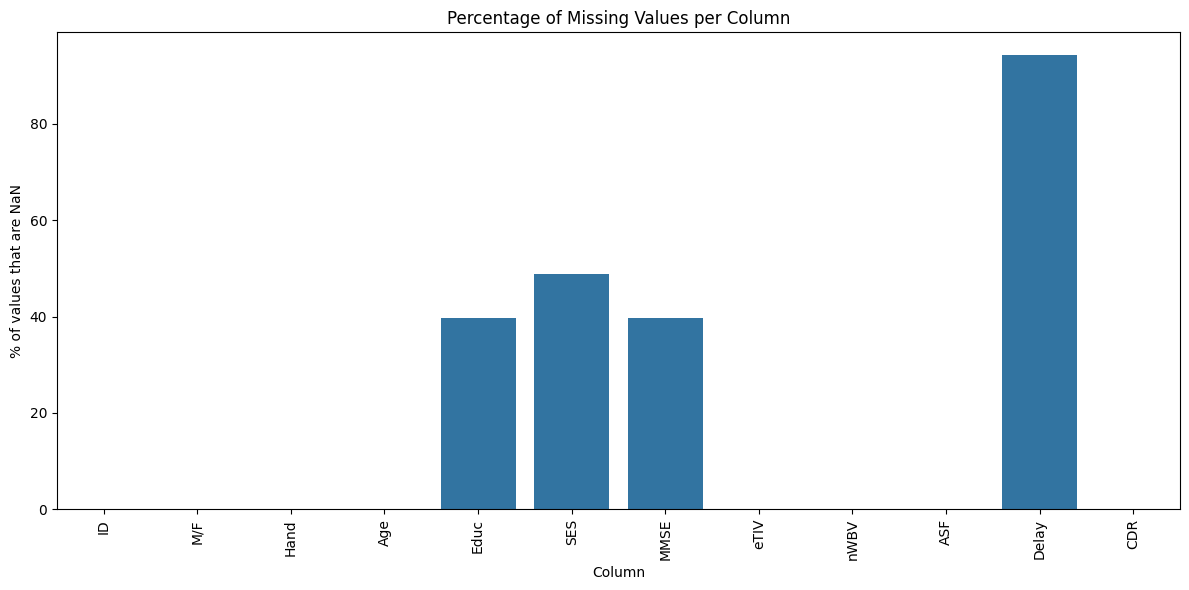

In [4]:
#To show all columns and rows in the outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# Missingness summary: total + per-column (all cols)
total_missing = df_test.isnull().sum().sum()
missing_per_col = df_test.isnull().sum()

print("\n\033[1mTotal missing values in dataset:\033[0m", total_missing)
print("\n\033[1mMissing values per column:\033[0m")
display(missing_per_col)

# Bar plot of % missing per column
missing_table= (
    missing_per_col
    .reset_index()
    .rename(columns={'index': 'column', 0: 'missing_count'})
)

missing_table['missing_percent'] = (
    missing_table['missing_count'] / len(df_test) * 100
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data= missing_table,
    x='column',
    y='missing_percent'
)
plt.xticks(rotation=90)
plt.ylabel('% of values that are NaN')
plt.xlabel('Column')
plt.title('Percentage of Missing Values per Column')
plt.tight_layout()
plt.show()

So the dataset provides two cognitive scores we can used for supervised ML: MMSE and CDR. MMSE should not be used due to 50% of the values missing, so we wanted to see how (im)balanced our class datasets were with CDR.

In [5]:
# Looking at stratified training set only again, for CDR proportions
X_c = df.drop(columns=["CDR"]) #CDR being the target variable
y_c = df["CDR"]

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_c,
    y_c,
    test_size=0.2,
    stratify=y_c       # To keep class proportions similar in train/test sets, without peeking at test set for good ML practices.
)

df_test = X_c_test.copy()
df_test["CDR"] = y_c_test     # you stratified on CDR, not CDR_binary



# Show how many participants per CDR class in train set
print("\n= Train set CDR class counts")
print(y_c_train.value_counts().sort_index())

# Percentages of each class
print("\n= Train set CDR class percentages")
print((y_c_train.value_counts(normalize=True) * 100).sort_index())



= Train set CDR class counts
CDR
0.0    268
0.5     56
1.0     22
2.0      2
Name: count, dtype: int64

= Train set CDR class percentages
CDR
0.0    77.011494
0.5    16.091954
1.0     6.321839
2.0     0.574713
Name: proportion, dtype: float64


In [6]:
# 1. Keep only rows with a valid CDR label
df_cognitive = df.dropna(subset=['CDR'])

# 2. Define features (X) and target (y)
X_c = df_cognitive.drop(columns=['CDR'])
y_c = df_cognitive['CDR']

# Stratify 80:20 train/test split
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_c,
    y_c,
    test_size=0.2,
    stratify=y_c,       # To keep class proportions similar in train/test sets, without peeking at test set for good ML practices.
    random_state=42   # for reproducibility
)

# Show how many participants per CDR class in train set
print("\n= Train set CDR class counts")
print(y_c_train.value_counts().sort_index())

# Percentages of each class
print("\n =  Train set CDR class percentages")
print((y_c_train.value_counts(normalize=True) * 100).sort_index())



= Train set CDR class counts
CDR
0.0    268
0.5     56
1.0     22
2.0      2
Name: count, dtype: int64

 =  Train set CDR class percentages
CDR
0.0    77.011494
0.5    16.091954
1.0     6.321839
2.0     0.574713
Name: proportion, dtype: float64


This next section involves multiple parts. Although we will explain this in terms of feature selection (dropping features) first, the coding order is reversed (adding new features (feature extraction) and datasets first); we wanted to merge all datasets together before dropping irrelevant variables. 

#### 1) 

Due to the CDR classes being very imbalanced, we decided to collapse CDR into CDR = 0 and CDR > 0. While future classes, the datasets we could fine online (Kaggle) or within our lab (ADNI) did not have sufficient people with CDR > 0.5 in either category. Although this would be ideal to gauge in the future, our research question does not focus on people with clinical AD dementia diagnosis. As other literature has already worked on predicting MCI to AD conversion, we wanted to better to identify individuals with cognitive impairment long ahead of clinical diagnosis and even for individuals with cognitive impairment (and even that preceding, or fuzzily overlapping with MCI).

Furthermore, we decided to add a new dataset in ADNI (with equivalent categories of CDR = 0 and CDR > 0). This data is also as baseline_data.csv. For purposes of this class (and this code already as long as it is), we have just included the number of final features after EDA processing to only include features that were used for comparing our final ML models. Our ADNI data (from a theory and processing level) has equivalent data quality and metrics relative to OASIS-1.

We did consider bootstrapping, but given the nature of diagnosing someone for cognitive impairment and AD risk, we decided not to go with synthetically-generated data based off 22 (6.32%) or 2 (0.57%) of the total sample size of the training set! This is not much to train a better ML model on, even before considering k-fold cross validation.




#### 2) 

We decided to perform some feature selection, wherein we used SynthSeg (https://www.sciencedirect.com/science/article/pii/S1361841523000506) to derive region-specific volumes. This is used in current papers employing ML models for cognitive impairment, and provdies more advantages than just a single, whole-brain metric; the IEEE-formatted report provides more justification on this, but briefly, different regions in AD are affected differentially (some worse, some more spared) over disease progression.

We initially extracted some brain regions (as seen in this dataset), but realized later dropped some features that we later found on weren't involved / strongly supported by the literature to be involved in early, preclinical AD progression (ex. thalamus).

##### 3)

We realized that because ~50% of SES, education, and MMSE scores were missing from our dataset, these variables had so little information that we did not trust their accuracy; we therefore dropped these features (feature selection). 

We also dropped 'Delay' due to the overwhelming majority of missing values.

We also decided to drop handedness, as there was no convincing literature of biological correlation between a person being left or right handed and their risk for cognitive impairment. 

 


In [7]:
#Feature extraction = Building new features from existing ones to use for ML
mri_df = pd.read_csv('oasis_roi_volumes.tsv', sep='\t') #provides regional brain volumes from MRI scans, instead of just total brain volume.
mri_df.head()

subject_id  lh_lateral_ventricle  rh_lateral_ventricle  lh_hippocampus  \
0  OAS1_0001_MR1               27846.0               23059.0          3504.0   
1  OAS1_0002_MR1                3249.0                3074.0          3785.0   
2  OAS1_0003_MR1               22584.0               19983.0          2795.0   
3  OAS1_0004_MR1               16162.0               11819.0          3929.0   
4  OAS1_0005_MR1                4790.0                4224.0          4881.0   

   rh_hippocampus  lh_entorhinal  rh_entorhinal  lh_parahippocampal  \
0          3905.0          923.0          782.0              1027.0   
1          4285.0         1113.0         1012.0              1453.0   
2          2891.0          668.0          459.0              1254.0   
3          4237.0         1040.0         1480.0              1508.0   
4          4690.0         1576.0         1203.0              2308.0   

   rh_parahippocampal  lh_thalamus  rh_thalamus  
0              1186.0       5352.0       5521.0  
1              1832.0       5550.0       5656.0  
2              1195.0       5692.0       5682.0  
3              1751.0       6796.0       6737.0  
4              1996.0       7828.0       7491.0

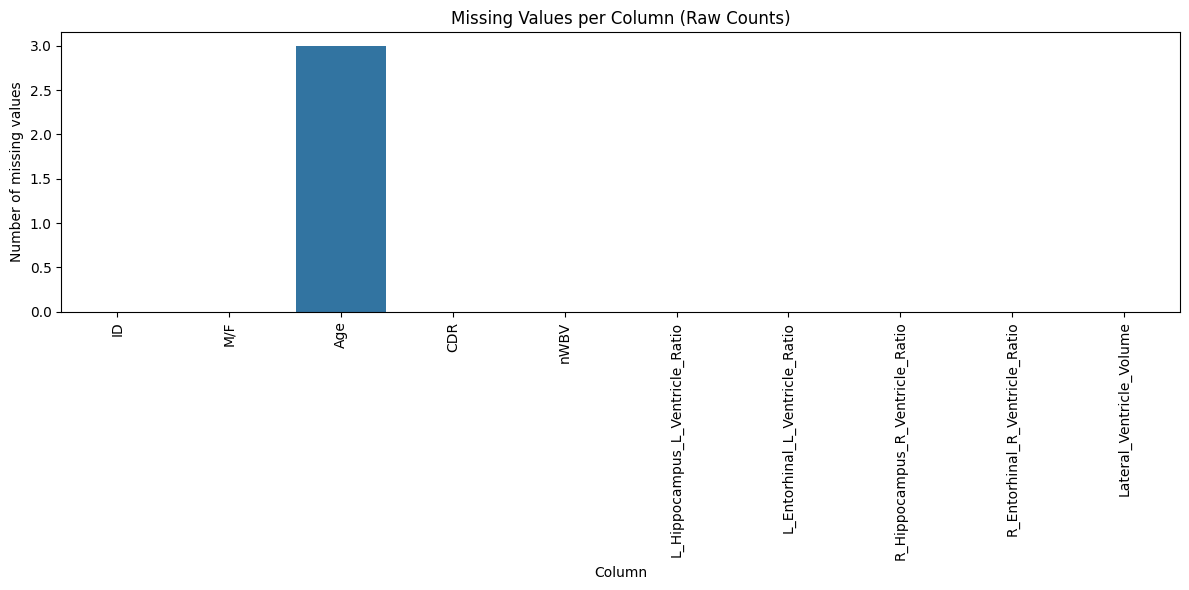

In [8]:
#To read in ADNI baseline dataset, to combine with OASIS dataset for larger sample size given what we have.
adni_df = pd.read_csv('baseline_data.csv')

# adni_df.head() ## optional, to show data if needed

# Create table for plotting raw counts of missing values per column
missing_per_col1 = adni_df.isnull().sum()
missing_table1 = (
    missing_per_col1
    .reset_index()
    .rename(columns={'index': 'column', 0: 'missing_count'})
)

# Plot raw counts instead of %
plt.figure(figsize=(12, 6))
sns.barplot(
    data=missing_table1,
    x='column',
    y='missing_count'   
)
plt.xticks(rotation=90)
plt.ylabel('Number of missing values')    
plt.xlabel('Column')
plt.title('Missing Values per Column (Raw Counts)')
plt.tight_layout()
plt.show()

In [9]:

# Further engineering for OASIS, which we couldn't do directly unlike extracting data from MRI ADNI dataset:

# Dropping rows with missing values in ADNI dataset
adni_df = adni_df.dropna(how='any') #just removes the categorical rows with missing age, as visualized above


# Further processing in OASIS dataset, and then merging with new OASIS tsv with regional volumes:

# Drop any rows with _MR2 in ID column (keep only baseline scans)
df = df[~df['ID'].str.contains('_MR2', na=False)]

# Drop specified columns
df = df.drop(columns=['Educ', 'SES', 'MMSE', 'eTIV', 'Delay','Hand'])

# Load MRI volumes
mri_df = pd.read_csv('oasis_roi_volumes.tsv', sep='\t')

# Merge the dataframes on subject ID
df = df.merge(mri_df, left_on='ID', right_on='subject_id', how='inner')

# Drop the redundant subject_id column from mri_df
df = df.drop(columns=['subject_id'])

# Get all columns that contain 'lh_' or 'rh_' (ROI volumes)
roi_columns = [col for col in df.columns if 'lh_' in col or 'rh_' in col]

# Scale ROI volumes by ASF for each subject
for col in roi_columns:
    df[col] = df[col] * df['ASF']

# Drop ASF column after scaling
df = df.drop(columns=['ASF'])

# Create new dataframe with engineered ratio features
new_df = pd.DataFrame()
new_df['ID'] = df['ID']
new_df['M/F'] = df['M/F']
new_df['Age'] = df['Age']
new_df['CDR'] = df['CDR']
new_df['nWBV'] = df['nWBV']

# Create ratio features
new_df['L_Hippocampus_L_Ventricle_Ratio'] = df['lh_hippocampus'] / df['lh_lateral_ventricle']
new_df['L_Entorhinal_L_Ventricle_Ratio'] = df['lh_entorhinal'] / df['lh_lateral_ventricle']
new_df['R_Hippocampus_R_Ventricle_Ratio'] = df['rh_hippocampus'] / df['rh_lateral_ventricle']
new_df['R_Entorhinal_R_Ventricle_Ratio'] = df['rh_entorhinal'] / df['rh_lateral_ventricle']
new_df['Lateral_Ventricle_Volume'] = (df['lh_lateral_ventricle'] + df['rh_lateral_ventricle'])

# Combined with ADNI dataset, which we also created similar engineered features by SynthSeg for MRI.
new_df = pd.concat([new_df, adni_df], axis=0, ignore_index=True)


# Collapse all CDR ratings to binary: 0 = no cognitive impairment, 1 = cognitive impairment (CDR>0). More balanced classes
new_df['CDR_binary'] = (new_df['CDR'] > 0).astype(int)

In [10]:

# Code to do EDA and compare volume ratios between CDR=0 and CDR>0 groups, training set only, pt. 1

# Cleaning up features in combined dataframe for EDA
X = new_df.drop(columns=['ID', 'CDR','CDR_binary'])
y = new_df['CDR_binary']

#Convert M/F into sex again in new dataset
if 'M/F' in X.columns:
    X['M/F'] = X['M/F'].map({'M': 1, 'F': 0})

# Split into train and test sets (80:20), stratified by CDR_binary
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



# Get list of columns with at least 1 missing value
nulls_per_column = X_train_full.isnull().sum()
cols_with_missing = nulls_per_column[nulls_per_column > 0].index.tolist()

if len(cols_with_missing) == 0:
    print("✅ No columns in X_train_full have missing values.")
else:
    print("⚠️ Columns with missing values:")
    for col in cols_with_missing:
        print(f" - {col}: {nulls_per_column[col]} missing")


✅ No columns in X_train_full have missing values.


In [11]:
# Refresh (with numerical values now) for into train and test sets (80:20), stratified by CDR_binary
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Not peeking into test set.
X_train_full.head()


# CDR_binary removed from X in ML to not count CDR itself as a feature, but can visualize with y.head()

M/F   Age      nWBV  L_Hippocampus_L_Ventricle_Ratio  \
347     1  69.0  0.794000                         0.325298   
679     1  72.6  0.752774                         0.072749   
507     0  61.8  0.772938                         0.382051   
872     1  71.8  0.768279                         0.228798   
1132    1  67.2  0.823238                         0.332189   

      L_Entorhinal_L_Ventricle_Ratio  R_Hippocampus_R_Ventricle_Ratio  \
347                         0.082448                         0.427198   
679                         0.085405                         0.085898   
507                         0.367226                         0.449493   
872                         0.186636                         0.209357   
1132                        0.391627                         0.363058   

      R_Entorhinal_R_Ventricle_Ratio  Lateral_Ventricle_Volume  
347                         0.076495              26235.506000  
679                         0.096944                  0.059247  
507                         0.449201                  0.013289  
872                         0.205557                  0.025187  
1132                        0.450223                  0.014530

In [12]:
# Show how many participants per CDR class in train set
print("\n= Train set CDR class counts")
print(y_train_full.value_counts().sort_index())

# Percentages of each class
print("\n =  Train set CDR class percentages")
print((y_train_full.value_counts(normalize=True) * 100).sort_index())


= Train set CDR class counts
CDR_binary
0    580
1    355
Name: count, dtype: int64

 =  Train set CDR class percentages
CDR_binary
0    62.032086
1    37.967914
Name: proportion, dtype: float64


Here, we can see that the new proportions of CDR are less imbalanced in the stratified training set (after simplifying to CDR = 0 vs CDR > 0). This. means that we can use a less-imbalanced (i.e. higher quality), larger dataset to try and classify when people have significant, preclinical biology leading into AD progression (even when said progression is preclinical-symptomatic).

Given that our model involves now CDR = 0 vs CDR > 0, we can later begin ML model employment via linear regression. 

In [13]:
#To demonstrate that volume across regions is consistent with biological expectations, we can visualize the data.
train_df = X_train_full.copy()
train_df['CDR_binary'] = y_train_full.values


# Columns of interest
ratio_cols = [
    'L_Hippocampus_L_Ventricle_Ratio',
    'L_Entorhinal_L_Ventricle_Ratio',
    'R_Hippocampus_R_Ventricle_Ratio',
    'R_Entorhinal_R_Ventricle_Ratio'
]
lat_col = 'Lateral_Ventricle_Volume'

# To encode means
group_means = train_df.groupby('CDR_binary')[ ratio_cols + [lat_col] ].mean()

# To compute mean differences (ratio_mean - lateral_mean) per group and overall
diffs = pd.DataFrame(index=group_means.index, columns=ratio_cols, dtype=float)

for grp in group_means.index:
    for r in ratio_cols:
        diffs.loc[grp, r] = group_means.loc[grp, r] - group_means.loc[grp, lat_col]


print("\nGroup means (by CDR = 0 (healthy) vs CDR > 0 (AD progression involving (sub)clinical cognitive impairment):")
print(group_means)


Group means (by CDR = 0 (healthy) vs CDR > 0 (AD progression involving (sub)clinical cognitive impairment):
            L_Hippocampus_L_Ventricle_Ratio  L_Entorhinal_L_Ventricle_Ratio  \
CDR_binary                                                                    
0                                  0.423855                        0.254022   
1                                  0.202997                        0.190536   

            R_Hippocampus_R_Ventricle_Ratio  R_Entorhinal_R_Ventricle_Ratio  \
CDR_binary                                                                    
0                                  0.453819                        0.250302   
1                                  0.214325                        0.207384   

            Lateral_Ventricle_Volume  
CDR_binary                            
0                       10289.099079  
1                       10933.291876  


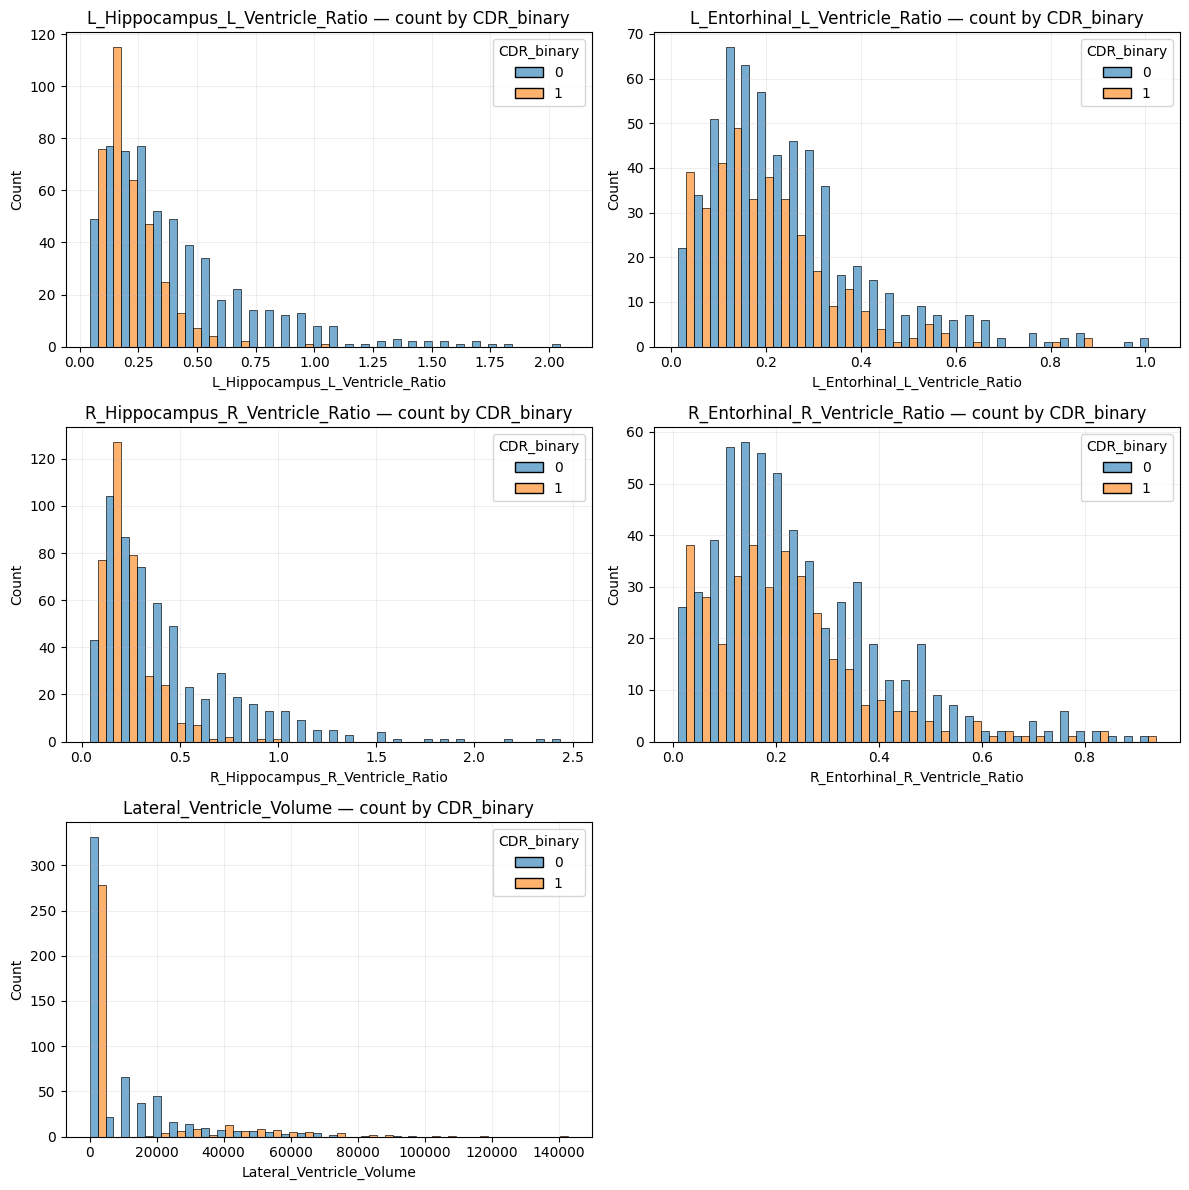

In [14]:
# Visualize distributions of ratio features and lateral ventricle volume by CDR_binary

# List of hippocampus/entorhinal-to-ventricle ratio features to plot
ratio_cols = [
    'L_Hippocampus_L_Ventricle_Ratio',
    'L_Entorhinal_L_Ventricle_Ratio',
    'R_Hippocampus_R_Ventricle_Ratio',
    'R_Entorhinal_R_Ventricle_Ratio'
]

# Lateral ventricle volume feature to include in the plots
lat_col = 'Lateral_Ventricle_Volume'

# Combine ratio features and ventricle volume into a single list to iterate over
vars_to_plot = ratio_cols + [lat_col]

# Number of variables to plot
n = len(vars_to_plot)

# Arrange subplots in a grid with 2 columns
cols = 2
rows = int(np.ceil(n / cols))  # minimum number of rows needed

# Create the figure and axes grid for subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()  # flatten to 1D array for easy indexing

# Loop over each variable and create a histogram
for i, var in enumerate(vars_to_plot):
    ax = axes[i]  # select the subplot axis for this variable

    # Subset to the current variable and CDR_binary; drop rows with missing values
    tmp = train_df[[var, 'CDR_binary']].dropna()

    # Number of histogram bins
    bins = 30
    try:
        # Let numpy choose appropriate bin edges based on the data distribution
        edges = np.histogram_bin_edges(tmp[var], bins=bins)
    except:
        # Fallback: if something goes wrong, just use an integer bin count
        edges = bins

    # Plot histogram of the current variable, split by CDR_binary
    sns.histplot(
        data=tmp,
        x=var,                  # feature on x-axis
        hue='CDR_binary',       # color by CDR group (0 vs >0)
        kde=False,              # no KDE curve, just histograms
        stat='count',           # y-axis shows raw counts
        bins=edges,             # bin edges from np.histogram_bin_edges
        palette=['C0', 'C1'],   # two colors for the two CDR groups
        alpha=0.6,              # transparency so overlaps are visible
        multiple='dodge',       # put bars side-by-side for each group
        common_norm=False,      # do not normalize across groups
        ax=ax                   # plot on this subplot axis
    )

    # Set title and basic axis formatting
    ax.set_title(f"{var} — count by CDR_binary")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.2)  # light grid for readability

# To hide unused subplot panels (i.e. the previous 6th empty graph) 
for j in range(n, len(axes)):
    axes[j].set_visible(False)


plt.tight_layout()
plt.show()

Based off the mean volume ratios across groups (and visualizing the count of ratio volumes (1/subject)), we can see that more of the biological features we engineered are smaller in CDR = 0 (healthy) vs CDR > 0 (early+ AD progression, with (sub)clinical dementia progression).

This provides some additional strengthening claim to our biological frameworks for feature extraction, on top of what has been explored in the literature (to see IEEE report for more justification).

## Logistic Regression

In [15]:
X_train_full.head()

M/F   Age      nWBV  L_Hippocampus_L_Ventricle_Ratio  \
347     1  69.0  0.794000                         0.325298   
679     1  72.6  0.752774                         0.072749   
507     0  61.8  0.772938                         0.382051   
872     1  71.8  0.768279                         0.228798   
1132    1  67.2  0.823238                         0.332189   

      L_Entorhinal_L_Ventricle_Ratio  R_Hippocampus_R_Ventricle_Ratio  \
347                         0.082448                         0.427198   
679                         0.085405                         0.085898   
507                         0.367226                         0.449493   
872                         0.186636                         0.209357   
1132                        0.391627                         0.363058   

      R_Entorhinal_R_Ventricle_Ratio  Lateral_Ventricle_Volume  
347                         0.076495              26235.506000  
679                         0.096944                  0.059247  
507                         0.449201                  0.013289  
872                         0.205557                  0.025187  
1132                        0.450223                  0.014530

LOGISTIC REGRESSION - Binary CDR Classification (0 vs >0)

Held-out test set size: 234
Test CDR=0: 145, CDR>0: 89

NESTED CROSS-VALIDATION (5 outer folds, 3 inner folds)
Optimizing for MACRO F1

--- Outer Fold 1/5 ---
Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Macro F1 (inner CV): 0.679
Validation Accuracy: 0.674
Validation Macro F1: 0.673
Validation AUC: 0.767
Confusion Matrix:
[[68 48]
 [13 58]]

--- Outer Fold 2/5 ---
Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Macro F1 (inner CV): 0.675
Validation Accuracy: 0.663
Validation Macro F1: 0.661
Validation AUC: 0.760
Confusion Matrix:
[[70 46]
 [17 54]]

--- Outer Fold 3/5 ---
Best params: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Macro F1 (inner CV): 0.680
Validation Accuracy: 0.674
Validation Macro F1: 0.670
Validation AUC: 0.759
Confusion Matrix:
[[73 43]
 [18 53]]

--- Outer Fold 4/5 ---
Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Macro F1 (inner CV): 0.684
V

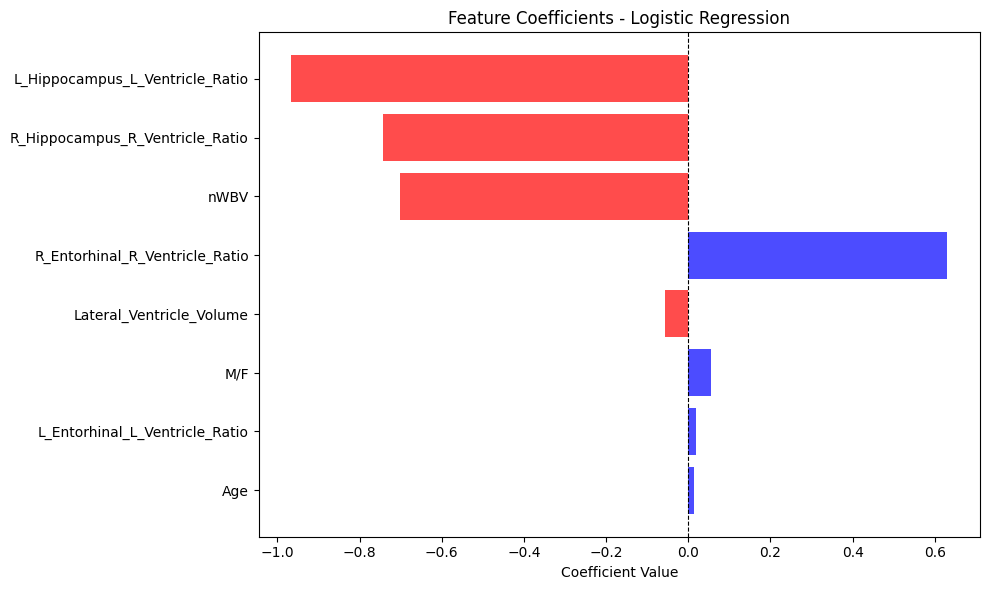

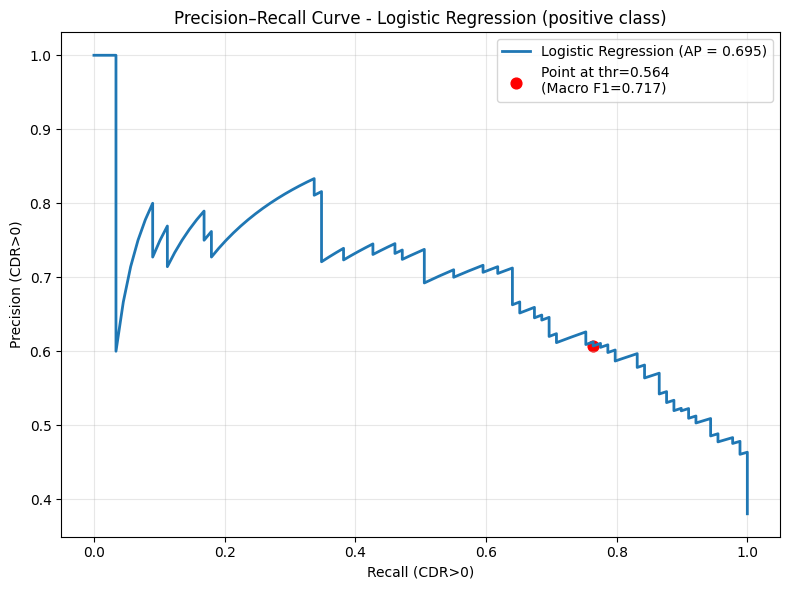


[TEST] Macro F1 at optimal threshold (0.564): 0.717


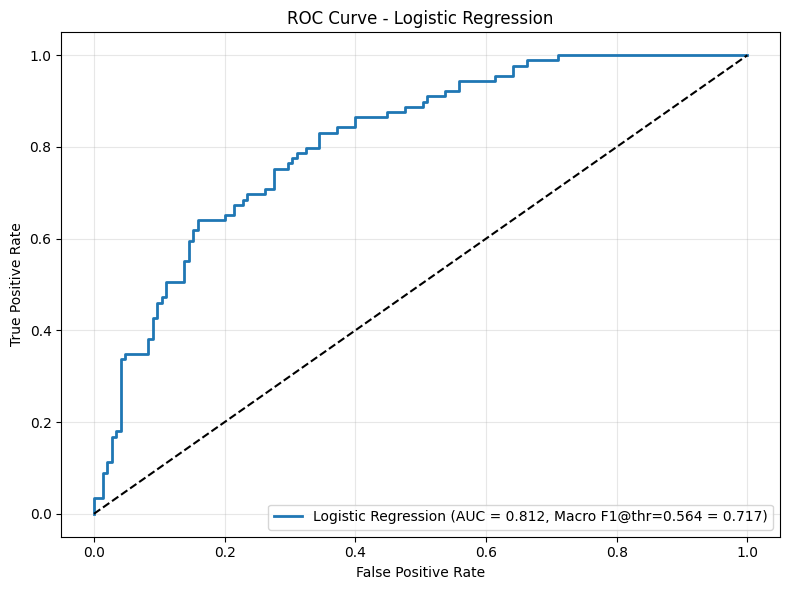


[CV] Cross-validated Macro F1 (full training size, default thr=0.50): 0.674


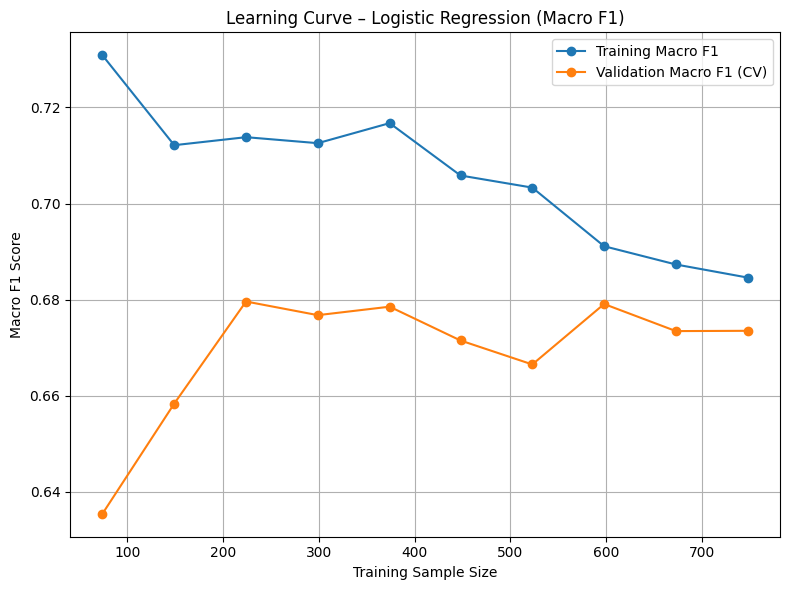

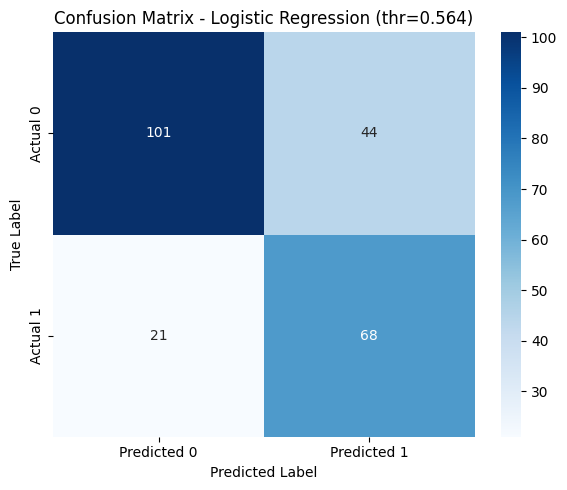

In [16]:
# =======================
# LOGISTIC REGRESSION – NESTED CV + FINAL EVAL
# (MACRO F1, data-driven threshold from training set)
# =======================

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_curve,
    classification_report, precision_score, recall_score
)

print("="*70)
print("LOGISTIC REGRESSION - Binary CDR Classification (0 vs >0)")
print("="*70)

print(f"\nHeld-out test set size: {len(X_test)}")
print(f"Test CDR=0: {sum(y_test==0)}, CDR>0: {sum(y_test==1)}")

# --- Nested CV setup ---
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Hyperparameter grid ---
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Storage for results
outer_scores_acc = []
outer_scores_f1 = []   # macro F1
outer_scores_auc = []
best_params_list = []

print("\n" + "="*70)
print("NESTED CROSS-VALIDATION (5 outer folds, 3 inner folds)")
print("Optimizing for MACRO F1")
print("="*70)

for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_full, y_train_full), 1):
    print(f"\n--- Outer Fold {fold_idx}/5 ---")
    
    X_train_fold = X_train_full.iloc[train_idx]
    X_val_fold   = X_train_full.iloc[val_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    y_val_fold   = y_train_full.iloc[val_idx]
    
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled   = scaler.transform(X_val_fold)
    
    # Inner CV: Grid search, scoring macro F1
    grid_search = GridSearchCV(
        LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train_fold)
    
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)
    
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best Macro F1 (inner CV): {grid_search.best_score_:.3f}")
    
    # Evaluate on validation fold (with default 0.5 threshold)
    y_val_pred  = best_model.predict(X_val_scaled)
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    fold_acc = accuracy_score(y_val_fold, y_val_pred)
    fold_f1  = f1_score(y_val_fold, y_val_pred, average='macro')
    fold_auc = roc_auc_score(y_val_fold, y_val_proba)
    
    outer_scores_acc.append(fold_acc)
    outer_scores_f1.append(fold_f1)
    outer_scores_auc.append(fold_auc)
    
    print(f"Validation Accuracy: {fold_acc:.3f}")
    print(f"Validation Macro F1: {fold_f1:.3f}")
    print(f"Validation AUC: {fold_auc:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))

# --- Nested CV Summary ---
print("\n" + "="*70)
print("NESTED CV SUMMARY (MACRO F1, threshold=0.50 during CV)")
print("="*70)
print(f"Mean Macro F1 across folds: {np.mean(outer_scores_f1):.3f} ± {np.std(outer_scores_f1):.3f}")
print(f"Macro F1 per fold: {[f'{s:.3f}' for s in outer_scores_f1]}")
print(f"\nMean AUC across folds: {np.mean(outer_scores_auc):.3f} ± {np.std(outer_scores_auc):.3f}")
print(f"AUC per fold: {[f'{s:.3f}' for s in outer_scores_auc]}")
print(f"\nMean Accuracy across folds: {np.mean(outer_scores_acc):.3f} ± {np.std(outer_scores_acc):.3f}")

print(f"\nMost common best params:")
for param in ['C', 'penalty', 'solver']:
    values = [p[param] for p in best_params_list]
    most_common = Counter(values).most_common(1)[0]
    print(f"  {param}: {most_common[0]} (appeared {most_common[1]}/5 folds)")

# --- Final model on held-out test set ---
print("\n" + "="*70)
print("FINAL MODEL ON HELD-OUT TEST SET")
print("(C from nested CV, threshold chosen on training set for best Macro F1)")
print("="*70)

final_C = Counter([p['C'] for p in best_params_list]).most_common(1)[0][0]
print(f"Using C: {final_C}")

scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_full)
X_test_scaled_final  = scaler_final.transform(X_test)

final_lr = LogisticRegression(
    C=final_C,
    class_weight='balanced',
    max_iter=5000,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)
final_lr.fit(X_train_scaled_final, y_train_full)

# --- Choose threshold on TRAINING set to maximize Macro F1 ---
y_train_proba = final_lr.predict_proba(X_train_scaled_final)[:, 1]

thresholds = np.linspace(0.0, 1.0, 501)
train_f1_scores = []

for thr in thresholds:
    y_train_pred_thr = (y_train_proba >= thr).astype(int)
    f1_thr = f1_score(y_train_full, y_train_pred_thr, average='macro')
    train_f1_scores.append(f1_thr)

best_idx = int(np.argmax(train_f1_scores))
best_threshold = float(thresholds[best_idx])
best_train_f1_macro = float(train_f1_scores[best_idx])

print(f"\nOptimal threshold (training, maximizing Macro F1): {best_threshold:.3f}")
print(f"Training Macro F1 at optimal threshold: {best_train_f1_macro:.3f}")

# --- Apply optimal threshold to TEST set ---
y_test_proba = final_lr.predict_proba(X_test_scaled_final)[:, 1]
y_test_pred_opt = (y_test_proba >= best_threshold).astype(int)

test_acc_opt      = accuracy_score(y_test, y_test_pred_opt)
test_f1_macro_opt = f1_score(y_test, y_test_pred_opt, average='macro')
test_auc          = roc_auc_score(y_test, y_test_proba)

print(f"\nTest Set Performance (threshold = {best_threshold:.3f}):")
print(f"Accuracy:   {test_acc_opt:.3f}")
print(f"Macro F1:   {test_f1_macro_opt:.3f}")
print(f"AUC-ROC:    {test_auc:.3f}")

print(f"\nClassification Report (per-class metrics, thr = {best_threshold:.3f}):")
print(classification_report(y_test, y_test_pred_opt, target_names=['CDR=0', 'CDR>0']))

# =======================
# FEATURE COEFFICIENTS
# =======================

feature_names = X.columns.tolist()
coef = final_lr.coef_.flatten()

sorted_idx = np.argsort(np.abs(coef))[::-1]

print("\n" + "="*70)
print("MODEL COEFFICIENTS (sorted by |coef|)")
print("="*70)
print(f"\nAll {len(feature_names)} features ranked by |coefficient|:")
for i, idx in enumerate(sorted_idx, 1):
    print(f"{i}. {feature_names[idx]}: {coef[idx]:.4f}")

plt.figure(figsize=(10, max(6, len(feature_names) * 0.4)))
y_pos = np.arange(len(feature_names))
colors = ['red' if c < 0 else 'blue' for c in coef[sorted_idx]]

plt.barh(y_pos, coef[sorted_idx], color=colors, alpha=0.7)
plt.yticks(y_pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients - Logistic Regression')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =======================
# PRECISION–RECALL + Macro F1 @ optimal threshold
# (PR curve is for positive class; macro F1 reported separately)
# =======================

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)

# Precision/recall at the chosen threshold on TEST (computed directly)
test_precision_opt = precision_score(y_test, y_test_pred_opt, pos_label=1)
test_recall_opt    = recall_score(y_test, y_test_pred_opt,    pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(
    recall, precision, linewidth=2,
    label=f'Logistic Regression (AP = {ap_score:.3f})'
)
plt.scatter(
    [test_recall_opt], [test_precision_opt],
    s=60,
    color='red',  # make the point red
    label=f'Point at thr={best_threshold:.3f}\n(Macro F1={test_f1_macro_opt:.3f})'
)
plt.xlabel("Recall (CDR>0)")
plt.ylabel("Precision (CDR>0)")
plt.title("Precision–Recall Curve - Logistic Regression (positive class)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n[TEST] Macro F1 at optimal threshold ({best_threshold:.3f}): {test_f1_macro_opt:.3f}")

# =======================
# ROC CURVE (with Macro F1 at optimal threshold)
# =======================

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    linewidth=2,
    label=(
        f'Logistic Regression (AUC = {test_auc:.3f}, '
        f'Macro F1@thr={best_threshold:.3f} = {test_f1_macro_opt:.3f})'
    )
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =======================
# LEARNING CURVE — MACRO F1 (still uses default 0.5 inside CV)
# =======================

lr_model_for_curve = LogisticRegression(
    C=final_C,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

train_sizes, train_scores, val_scores = learning_curve(
    lr_model_for_curve,
    X_train_scaled_final,
    y_train_full,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

cv_f1_full = val_mean[-1]
print(f"\n[CV] Cross-validated Macro F1 (full training size, default thr=0.50): {cv_f1_full:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Macro F1')
plt.plot(train_sizes, val_mean,  'o-', label='Validation Macro F1 (CV)')
plt.xlabel("Training Sample Size")
plt.ylabel("Macro F1 Score")
plt.title("Learning Curve – Logistic Regression (Macro F1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =======================
# CONFUSION MATRIX — optimal threshold
# =======================

cm = confusion_matrix(y_test, y_test_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1']
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Logistic Regression (thr={best_threshold:.3f})")
plt.tight_layout()
plt.show()

## SVM

Class distribution:
CDR_binary
0    725
1    444
Name: count, dtype: int64

Class proportions:
CDR_binary
0    0.620188
1    0.379812
Name: proportion, dtype: float64

Held-out test set size: 234
Test CDR=0: 145, CDR>0: 89

NESTED CROSS-VALIDATION (5 outer folds, 3 inner folds)
Optimizing for MACRO F1

--- Outer Fold 1/5 ---
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Macro F1 (inner CV): 0.684
Validation AUC:      0.776
Validation Macro F1: 0.679
Confusion Matrix:
[[67 49]
 [11 60]]

--- Outer Fold 2/5 ---
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Macro F1 (inner CV): 0.673
Validation AUC:      0.731
Validation Macro F1: 0.666
Confusion Matrix:
[[70 46]
 [16 55]]

--- Outer Fold 3/5 ---
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Macro F1 (inner CV): 0.686
Validation AUC:      0.749
Validation Macro F1: 0.662
Confusion Matrix:
[[66 50]
 [13 58]]

--- Outer Fold 4/5 ---
Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Be

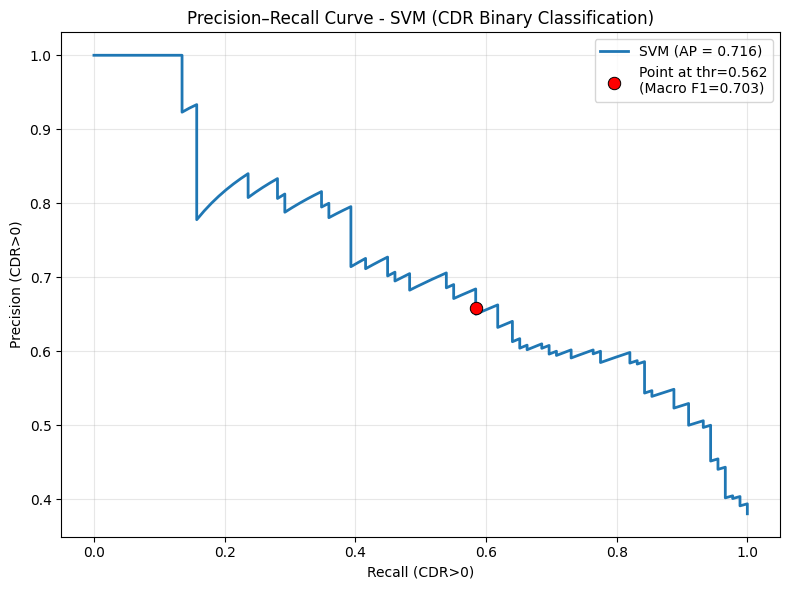


[TEST] Macro F1 at optimal threshold (0.562): 0.703


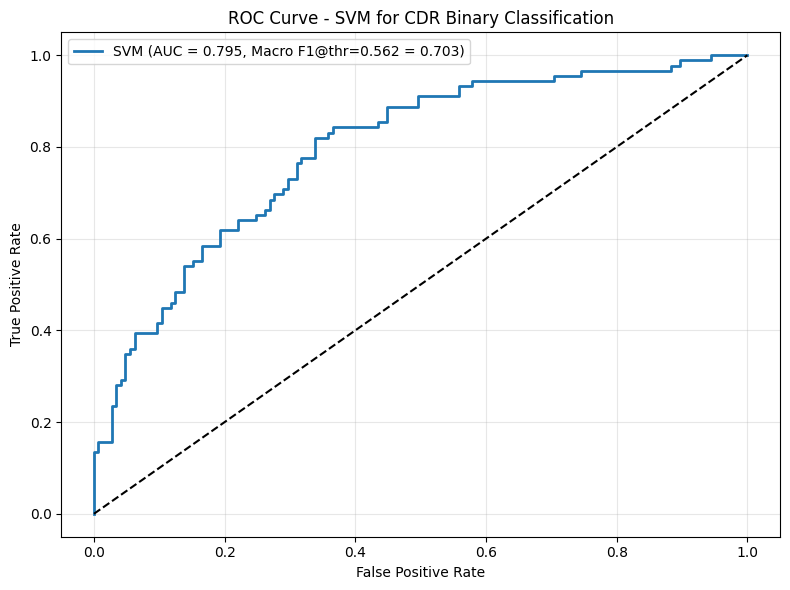


[CV] Cross-validated Macro F1 (full training size): 0.662


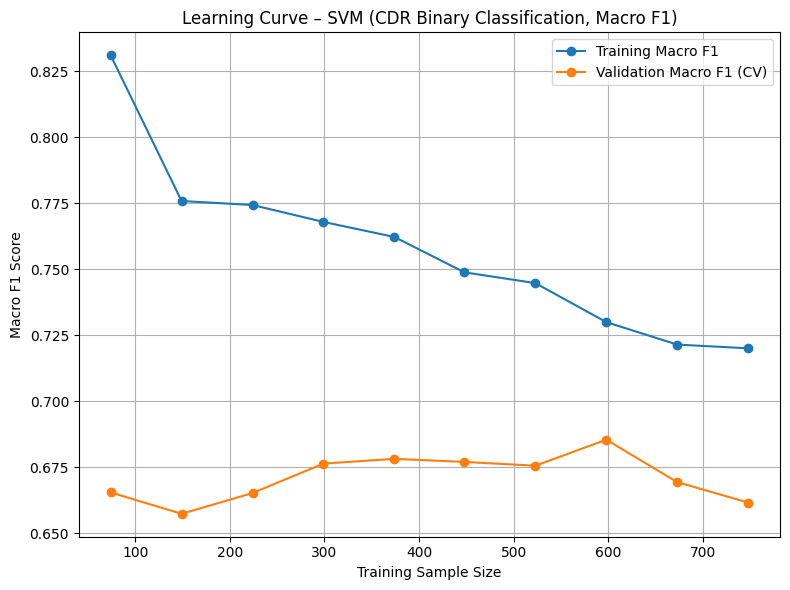

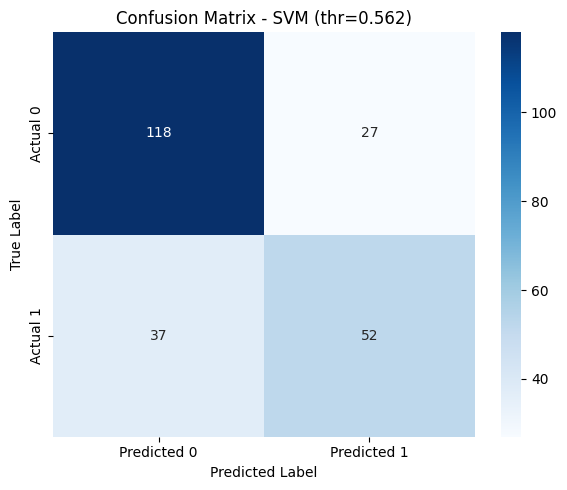

In [17]:
# =======================
# SVM – NESTED CV + FINAL EVAL
# (MACRO F1, data-driven threshold from training set)
# =======================

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    make_scorer, f1_score,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score
)

# -----------------------
# 0. DATA PREP
# -----------------------

# Create binary target: 0 vs non-0
new_df['CDR_binary'] = (new_df['CDR'] > 0).astype(int)

print("Class distribution:")
print(new_df['CDR_binary'].value_counts())
print("\nClass proportions:")
print(new_df['CDR_binary'].value_counts(normalize=True))

# Features
X = new_df.drop(columns=['ID', 'CDR', 'CDR_binary'])

# Encode M/F as binary
X['M/F'] = (X['M/F'] == 'M').astype(int)

y = new_df['CDR_binary']

# Hold-out test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nHeld-out test set size: {len(X_test)}")
print(f"Test CDR=0: {sum(y_test==0)}, CDR>0: {sum(y_test==1)}")

# -----------------------
# 1. NESTED CV (MACRO F1)
# -----------------------

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

# MACRO F1 scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')

outer_scores_auc = []
outer_scores_f1 = []
best_params_list = []

print("\n" + "="*60)
print("NESTED CROSS-VALIDATION (5 outer folds, 3 inner folds)")
print("Optimizing for MACRO F1")
print("="*60)

for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_full, y_train_full), 1):
    print(f"\n--- Outer Fold {fold_idx}/5 ---")
    
    X_train_fold = X_train_full.iloc[train_idx]
    X_val_fold   = X_train_full.iloc[val_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    y_val_fold   = y_train_full.iloc[val_idx]
    
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled   = scaler.transform(X_val_fold)
    
    # Inner CV: grid search with MACRO F1
    grid_search = GridSearchCV(
        SVC(class_weight='balanced', probability=True, random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring=f1_macro_scorer,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_scaled, y_train_fold)
    
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)
    
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best Macro F1 (inner CV): {grid_search.best_score_:.3f}")
    
    # Evaluate on validation fold (default 0.5 threshold via predict)
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    y_val_pred  = best_model.predict(X_val_scaled)
    
    fold_auc = roc_auc_score(y_val_fold, y_val_proba)
    fold_f1  = f1_score(y_val_fold, y_val_pred, average='macro')
    
    outer_scores_auc.append(fold_auc)
    outer_scores_f1.append(fold_f1)
    
    print(f"Validation AUC:      {fold_auc:.3f}")
    print(f"Validation Macro F1: {fold_f1:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))

# Summary
print("\n" + "="*60)
print("NESTED CV SUMMARY (MACRO F1)")
print("="*60)
print(f"Mean Macro F1 across folds: {np.mean(outer_scores_f1):.3f} ± {np.std(outer_scores_f1):.3f}")
print(f"Macro F1 per fold: {[f'{s:.3f}' for s in outer_scores_f1]}")
print(f"\nMean AUC across folds: {np.mean(outer_scores_auc):.3f} ± {np.std(outer_scores_auc):.3f}")
print(f"AUC per fold: {[f'{s:.3f}' for s in outer_scores_auc]}")

print("\nMost common best params:")
for param in ['kernel', 'C', 'gamma']:
    values = [p[param] for p in best_params_list]
    most_common = Counter(values).most_common(1)[0]
    print(f"  {param}: {most_common[0]} (appeared {most_common[1]}/5 folds)")

# -----------------------
# 2. FINAL MODEL + DATA-DRIVEN THRESHOLD (MACRO F1)
# -----------------------

final_kernel = Counter([p['kernel'] for p in best_params_list]).most_common(1)[0][0]
final_C      = Counter([p['C']      for p in best_params_list]).most_common(1)[0][0]
final_gamma  = Counter([p['gamma']  for p in best_params_list]).most_common(1)[0][0]

print("\n" + "="*60)
print("FINAL MODEL ON HELD-OUT TEST SET")
print("="*60)
print(f"Using hyperparameters: kernel={final_kernel}, C={final_C}, gamma={final_gamma}")

scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_full)
X_test_scaled_final  = scaler_final.transform(X_test)

svm_final = SVC(
    kernel=final_kernel,
    C=final_C,
    gamma=final_gamma,
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_final.fit(X_train_scaled_final, y_train_full)

# --- Choose threshold on TRAINING set to maximize MACRO F1 ---
y_train_proba = svm_final.predict_proba(X_train_scaled_final)[:, 1]

thresholds = np.linspace(0.0, 1.0, 501)
train_f1_macro_scores = []

for thr in thresholds:
    y_train_pred_thr = (y_train_proba >= thr).astype(int)
    f1_thr = f1_score(y_train_full, y_train_pred_thr, average='macro')
    train_f1_macro_scores.append(f1_thr)

best_idx = int(np.argmax(train_f1_macro_scores))
best_threshold = float(thresholds[best_idx])
best_train_f1_macro = float(train_f1_macro_scores[best_idx])

print(f"\nOptimal threshold on TRAINING (max Macro F1): {best_threshold:.3f}")
print(f"Training Macro F1 at optimal threshold:      {best_train_f1_macro:.3f}")

# --- Apply optimal threshold to TEST set ---
y_test_proba   = svm_final.predict_proba(X_test_scaled_final)[:, 1]
y_test_pred_opt = (y_test_proba >= best_threshold).astype(int)

test_auc          = roc_auc_score(y_test, y_test_proba)
test_f1_macro_opt = f1_score(y_test, y_test_pred_opt, average='macro')

print(f"\nTest Set Performance (threshold = {best_threshold:.3f}):")
print(f"AUC-ROC:    {test_auc:.3f}")
print(f"Macro F1:   {test_f1_macro_opt:.3f}")

print("\nClassification Report (thr = {:.3f}):".format(best_threshold))
print(classification_report(y_test, y_test_pred_opt, target_names=['CDR=0', 'CDR>0']))

print("Confusion Matrix (Test, thr = {:.3f}):".format(best_threshold))
print(confusion_matrix(y_test, y_test_pred_opt))

# -----------------------
# 3. PRECISION–RECALL CURVE (with red point at optimal threshold)
# -----------------------

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)

# Precision/recall at chosen threshold on TEST (compute directly)
test_precision_opt = precision_score(y_test, y_test_pred_opt, pos_label=1)
test_recall_opt    = recall_score(y_test, y_test_pred_opt,    pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(
    recall, precision, linewidth=2,
    label=f"SVM (AP = {ap_score:.3f})"
)
plt.scatter(
    [test_recall_opt], [test_precision_opt],
    s=80,
    color='red',
    edgecolor='black',
    linewidth=0.7,
    zorder=5,
    label=f'Point at thr={best_threshold:.3f}\n(Macro F1={test_f1_macro_opt:.3f})'
)
plt.xlabel("Recall (CDR>0)")
plt.ylabel("Precision (CDR>0)")
plt.title("Precision–Recall Curve - SVM (CDR Binary Classification)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n[TEST] Macro F1 at optimal threshold ({best_threshold:.3f}): {test_f1_macro_opt:.3f}")

# -----------------------
# 4. ROC CURVE (annotated with Macro F1 @ optimal threshold)
# -----------------------

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    linewidth=2,
    label=(
        f"SVM (AUC = {test_auc:.3f}, "
        f"Macro F1@thr={best_threshold:.3f} = {test_f1_macro_opt:.3f})"
    )
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM for CDR Binary Classification")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# 5. LEARNING CURVE – MACRO F1
# -----------------------

svm_model_for_curve = SVC(
    kernel=final_kernel,
    C=final_C,
    gamma=final_gamma,
    class_weight='balanced',
    probability=True,
    random_state=42
)

train_sizes, train_scores, val_scores = learning_curve(
    svm_model_for_curve,
    X_train_scaled_final,
    y_train_full,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

cv_f1_full = val_mean[-1]
print(f"\n[CV] Cross-validated Macro F1 (full training size): {cv_f1_full:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Macro F1')
plt.plot(train_sizes, val_mean,  'o-', label='Validation Macro F1 (CV)')
plt.xlabel("Training Sample Size")
plt.ylabel("Macro F1 Score")
plt.title("Learning Curve – SVM (CDR Binary Classification, Macro F1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# 6. CONFUSION MATRIX – optimal threshold
# -----------------------

cm = confusion_matrix(y_test, y_test_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1']
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SVM (thr={best_threshold:.3f})")
plt.tight_layout()
plt.show()

In [18]:
#removed code for graphs

As evident here by the learning curves, the SVM training data did not perform much better over increasing training sample sizes.

By how it separates classes through hyperplanes, SVM is not failing; however, this indicates to use that our features basically interact with each other in similar ways. Considering performance between logistic regression, our biologically-designed features, and reported metrics, logistic regression likely serves as a superior model (by model computational effiency) given our features

# Merge

## XGBoost

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("="*70)
print("XGBoost Classifier with Nested CV - Binary CDR Classification")
print("="*70)

# --- CREATE BINARY TARGET (CDR=0 vs CDR>0) ---
new_df['CDR_binary'] = (new_df['CDR'] > 0).astype(int)

# Check class distribution
print("\nClass distribution:")
print(new_df['CDR_binary'].value_counts())
print(f"\nClass proportions:")
print(new_df['CDR_binary'].value_counts(normalize=True))

# --- Prepare features (SAME AS SVM) ---
X = new_df.drop(columns=['ID', 'CDR', 'CDR_binary'])

# Encode M/F as binary (0/1)
X['M/F'] = (X['M/F'] == 'M').astype(int)

y = new_df['CDR_binary']

print(f"\nFeature shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

# --- Hold out test set (20%) ---
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nHeld-out test set size: {len(X_test)}")
print(f"Test CDR=0: {sum(y_test==0)}, CDR>0: {sum(y_test==1)}")
print(f"Training set size: {len(X_train_full)}")
print(f"Train CDR=0: {sum(y_train_full==0)}, CDR>0: {sum(y_train_full==1)}")

# Calculate scale_pos_weight
scale_pos_weight = sum(y_train_full==0) / sum(y_train_full==1)
print(f"\nScale pos weight (CDR=0 / CDR>0): {scale_pos_weight:.4f}")

# --- Nested CV setup ---
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Stage 1: Coarse hyperparameter search ---
print("\n" + "="*70)
print("STAGE 1: Coarse hyperparameter search")
print("="*70)

param_grid_coarse = {
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_coarse = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

grid_coarse = GridSearchCV(
    xgb_coarse,
    param_grid_coarse,
    cv=inner_cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print(f"\nSearching combinations with 3-fold inner CV...")
grid_coarse.fit(X_train_full, y_train_full)

print(f"\nBest coarse parameters: {grid_coarse.best_params_}")
print(f"Best coarse CV F1: {grid_coarse.best_score_:.4f}")

# --- Stage 2: Fine-tune around best coarse parameters ---
print("\n" + "="*70)
print("STAGE 2: Fine-tuning around best parameters")
print("="*70)

best_coarse = grid_coarse.best_params_

param_grid_fine = {
    'max_depth': [max(2, best_coarse['max_depth']-1), best_coarse['max_depth'], min(5, best_coarse['max_depth']+1)],
    'min_child_weight': [max(1, best_coarse['min_child_weight']-2), best_coarse['min_child_weight'], min(10, best_coarse['min_child_weight']+2)],
    'gamma': [0, 0.1, 0.5] if best_coarse['gamma'] == 0 else [0, best_coarse['gamma'], min(1.0, best_coarse['gamma']+0.2)],
    'learning_rate': [0.01, best_coarse['learning_rate'], min(0.2, best_coarse['learning_rate']+0.05)],
    'n_estimators': [best_coarse['n_estimators'], min(400, best_coarse['n_estimators']+100)],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, best_coarse['reg_lambda'], min(10, best_coarse['reg_lambda']+5)],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_fine = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

grid_fine = GridSearchCV(
    xgb_fine,
    param_grid_fine,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print(f"\nFine-tuning with 5-fold CV...")
grid_fine.fit(X_train_full, y_train_full)

print(f"\nBest fine-tuned parameters: {grid_fine.best_params_}")
print(f"Best fine-tuned CV F1: {grid_fine.best_score_:.4f}")

# --- Nested CV for unbiased performance estimate ---
print("\n" + "="*70)
print("NESTED CV: Unbiased performance estimation (5 outer folds)")
print("="*70)

outer_scores_acc = []
outer_scores_f1 = []
outer_scores_auc = []
best_params_list = []

for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_full, y_train_full), 1):
    print(f"\n--- Outer Fold {fold_idx}/5 ---")
    
    X_train_fold = X_train_full.iloc[train_idx]
    X_val_fold = X_train_full.iloc[val_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    y_val_fold = y_train_full.iloc[val_idx]
    
    # Inner CV: Grid search
    grid_search = GridSearchCV(
        xgb_fine,
        param_grid_fine,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_fold, y_train_fold)
    
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)
    
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best F1 (inner CV): {grid_search.best_score_:.3f}")
    
    # Evaluate on validation fold
    y_val_pred = best_model.predict(X_val_fold)
    y_val_proba = best_model.predict_proba(X_val_fold)[:, 1]
    
    fold_acc = accuracy_score(y_val_fold, y_val_pred)
    fold_f1 = f1_score(y_val_fold, y_val_pred, pos_label=1)
    fold_auc = roc_auc_score(y_val_fold, y_val_proba)
    
    outer_scores_acc.append(fold_acc)
    outer_scores_f1.append(fold_f1)
    outer_scores_auc.append(fold_auc)
    
    print(f"Validation Accuracy: {fold_acc:.3f}")
    print(f"Validation F1: {fold_f1:.3f}")
    print(f"Validation AUC: {fold_auc:.3f}")
    print(f"Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))

# --- Nested CV Summary ---
print("\n" + "="*70)
print("NESTED CV SUMMARY")
print("="*70)
print(f"Mean F1 across folds: {np.mean(outer_scores_f1):.3f} ± {np.std(outer_scores_f1):.3f}")
print(f"F1 per fold: {[f'{s:.3f}' for s in outer_scores_f1]}")
print(f"\nMean AUC across folds: {np.mean(outer_scores_auc):.3f} ± {np.std(outer_scores_auc):.3f}")
print(f"AUC per fold: {[f'{s:.3f}' for s in outer_scores_auc]}")
print(f"\nMean Accuracy across folds: {np.mean(outer_scores_acc):.3f} ± {np.std(outer_scores_acc):.3f}")

print(f"\nMost common best params:")
for param in ['max_depth', 'learning_rate', 'n_estimators', 'gamma']:
    values = [p[param] for p in best_params_list]
    most_common = Counter(values).most_common(1)[0]
    print(f"  {param}: {most_common[0]} (appeared {most_common[1]}/5 folds)")

# --- Final model on held-out test set ---
print("\n" + "="*70)
print("FINAL MODEL ON HELD-OUT TEST SET")
print("="*70)

# Use most common hyperparameters
final_params = {}
for param in param_grid_fine.keys():
    values = [p[param] for p in best_params_list]
    final_params[param] = Counter(values).most_common(1)[0][0]

print(f"Using hyperparameters: {final_params}")

final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    **final_params
)

final_xgb.fit(X_train_full, y_train_full)

y_test_pred = final_xgb.predict(X_test)
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1)
test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nTest Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['CDR=0', 'CDR>0']))

print(f"\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# --- PLOT 1: Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['CDR=0', 'CDR>0'], yticklabels=['CDR=0', 'CDR>0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Set)\nAccuracy: {accuracy:.3f}, F1: {test_f1:.3f}')
plt.tight_layout()
plt.show()

# --- PLOT 2: ROC Curve ---
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {test_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost for CDR Binary Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 3: Precision-Recall Curve with Best F1 Point ---
plt.figure(figsize=(8, 6))
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_precision = precision[best_f1_idx]
best_recall = recall[best_f1_idx]
best_threshold = thresholds_pr[best_f1_idx] if best_f1_idx < len(thresholds_pr) else 0.5

plt.plot(recall, precision, label=f'XGBoost (AP = {test_ap:.3f})', linewidth=2)
plt.scatter(best_recall, best_precision, color='red', s=100, zorder=5, 
            label=f'Best F1 = {best_f1:.3f} (threshold = {best_threshold:.3f})')
plt.axhline(y=sum(y_test)/len(y_test), color='k', linestyle='--', 
           label=f'Baseline (prevalence = {sum(y_test)/len(y_test):.3f})', linewidth=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest F1 threshold: {best_threshold:.4f}")
print(f"Best F1 score: {best_f1:.4f} (Precision: {best_precision:.4f}, Recall: {best_recall:.4f})")

# --- PLOT 4: Learning Curve (F1 vs Training Iterations) ---
print("\nCalculating learning curve (this may take a moment)...")
plt.figure(figsize=(10, 6))

# Calculate F1 scores at regular intervals across ALL iterations
train_f1_scores = []
test_f1_scores = []
iteration_points = list(range(10, final_params['n_estimators'] + 1, 10))
if final_params['n_estimators'] not in iteration_points:
    iteration_points.append(final_params['n_estimators'])

for i in iteration_points:
    temp_model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist',
        n_estimators=i,
        **{k: v for k, v in final_params.items() if k != 'n_estimators'}
    )
    temp_model.fit(X_train_full, y_train_full, verbose=False)
    
    train_pred = temp_model.predict(X_train_full)
    test_pred = temp_model.predict(X_test)
    train_f1_scores.append(f1_score(y_train_full, train_pred, pos_label=1))
    test_f1_scores.append(f1_score(y_test, test_pred, pos_label=1))

plt.plot(iteration_points, train_f1_scores, 'o-', label='Training F1', linewidth=2, markersize=5)
plt.plot(iteration_points, test_f1_scores, 's-', label='Test F1', linewidth=2, markersize=5)
plt.xlabel('Training Iterations (n_estimators)')
plt.ylabel('F1 Score')
plt.title('Learning Curve: F1 vs Training Iterations')
plt.xlim(0, final_params['n_estimators'])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Feature importance (visualize ALL features) ---
print("\n" + "="*70)
print("FEATURE IMPORTANCES (ALL FEATURES)")
print("="*70)

feature_importance = final_xgb.feature_importances_
feature_names = X.columns.tolist()

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]

print(f"\nAll {len(feature_names)} features ranked by importance:")
for i, idx in enumerate(sorted_idx, 1):
    print(f"{i}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

# Plot ALL features
plt.figure(figsize=(10, max(6, len(feature_names) * 0.4)))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, feature_importance[sorted_idx])
plt.yticks(y_pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance Score')
plt.title(f'All Feature Importances - XGBoost (n={len(feature_names)})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Final Summary ---
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nNested CV estimate (unbiased): {np.mean(outer_scores_f1):.3f} ± {np.std(outer_scores_f1):.3f}")
print(f"Test set performance: F1={test_f1:.3f}, AUC={test_auc:.3f}, AP={test_ap:.3f}")

XGBoost Classifier with Nested CV - Binary CDR Classification

Class distribution:
CDR_binary
0    725
1    444
Name: count, dtype: int64

Class proportions:
CDR_binary
0    0.620188
1    0.379812
Name: proportion, dtype: float64

Feature shape: (1169, 8)
Number of features: 8
Feature names: ['M/F', 'Age', 'nWBV', 'L_Hippocampus_L_Ventricle_Ratio', 'L_Entorhinal_L_Ventricle_Ratio', 'R_Hippocampus_R_Ventricle_Ratio', 'R_Entorhinal_R_Ventricle_Ratio', 'Lateral_Ventricle_Volume']

Held-out test set size: 234
Test CDR=0: 145, CDR>0: 89
Training set size: 935
Train CDR=0: 580, CDR>0: 355

Scale pos weight (CDR=0 / CDR>0): 1.6338

STAGE 1: Coarse hyperparameter search

Searching combinations with 3-fold inner CV...
Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learni

In [ ]:
# ==============================================================================
# FINAL XGBOOST ANALYSIS - COMPREHENSIVE EVALUATION
# ==============================================================================

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import learning_curve
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                            classification_report, roc_auc_score, roc_curve, 
                            precision_recall_curve, average_precision_score,
                            precision_score, recall_score)
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("FINAL XGBOOST MODEL - COMPREHENSIVE EVALUATION")
print("="*70)

# ==============================================================================
# STEP 1: EVALUATE ALL HYPERPARAMETER COMBINATIONS ON TEST SET
# ==============================================================================
print("\nEvaluating all hyperparameter combinations on test set...")

results_df = pd.DataFrame(grid_fine.cv_results_)
evaluation_results = []

# Get unique combinations and evaluate each on test set
for idx, row in results_df.iterrows():
    params = {
        'max_depth': row['param_max_depth'],
        'min_child_weight': row['param_min_child_weight'],
        'gamma': row['param_gamma'],
        'learning_rate': row['param_learning_rate'],
        'n_estimators': row['param_n_estimators'],
        'reg_alpha': row['param_reg_alpha'],
        'reg_lambda': row['param_reg_lambda'],
        'subsample': row['param_subsample'],
        'colsample_bytree': row['param_colsample_bytree']
    }
    
    # Train and evaluate
    temp_model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist',
        **params
    )
    temp_model.fit(X_train_full, y_train_full, verbose=False)
    y_pred = temp_model.predict(X_test)
    
    evaluation_results.append({
        'r': params['learning_rate'],
        'n': params['n_estimators'],
        'max_depth': params['max_depth'],
        'Precision': precision_score(y_test, y_pred, pos_label=1),
        'Recall': recall_score(y_test, y_pred, pos_label=1),
        'Best Accuracy %': accuracy_score(y_test, y_pred) * 100,
        'F1': f1_score(y_test, y_pred, pos_label=1),
        'all_params': params
    })

# Convert to DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Group by r and n, keep the best F1 for each combination
best_per_combo = eval_df.loc[eval_df.groupby(['r', 'n'])['F1'].idxmax()]

# Sort by F1 descending
best_per_combo = best_per_combo.sort_values('F1', ascending=False).reset_index(drop=True)

# ==============================================================================
# STEP 2: SELECT THE ABSOLUTE BEST MODEL
# ==============================================================================
best_idx = 0  # Highest F1
best_config = best_per_combo.iloc[best_idx]
best_params = best_config['all_params']
best_f1 = best_config['F1']

print(f"\n{'='*70}")
print("BEST CONFIGURATION (Highest Test F1)")
print(f"{'='*70}")
print(f"Learning Rate (r): {best_params['learning_rate']}")
print(f"N Trees (n):       {best_params['n_estimators']}")
print(f"Max Depth:         {best_params['max_depth']}")
print(f"F1 Score:          {best_f1:.3f}")

# ==============================================================================
# STEP 3: TRAIN FINAL MODEL WITH BEST PARAMS
# ==============================================================================
print(f"\nTraining final model with best configuration...")
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    **best_params
)

final_model.fit(X_train_full, y_train_full)

# Evaluate
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=1)
test_recall = recall_score(y_test, y_test_pred, pos_label=1)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1)
test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE (BEST MODEL)")
print(f"{'='*70}")
print(f"Accuracy:  {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"Precision: {test_precision:.3f}")
print(f"Recall:    {test_recall:.3f}")
print(f"F1 Score:  {test_f1:.3f}")
print(f"AUC-ROC:   {test_auc:.3f}")
print(f"Avg Prec:  {test_ap:.3f}")

# ==============================================================================
# PLOT 1: CONFUSION MATRIX
# ==============================================================================
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['CDR=0', 'CDR>0'], yticklabels=['CDR=0', 'CDR>0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Set)\nAccuracy: {test_accuracy:.3f}, F1: {test_f1:.3f}')
plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 2: ROC CURVE
# ==============================================================================
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {test_auc:.3f}, F1 = {test_f1:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost for CDR Binary Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 3: PRECISION-RECALL CURVE WITH BEST F1 POINT
# ==============================================================================
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# Calculate F1 at default threshold (0.5)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'XGBoost (AP = {test_ap:.3f})', linewidth=2)
# Mark the point corresponding to default threshold (our test_f1)
plt.scatter(test_recall, test_precision, color='red', s=100, zorder=5, 
            label=f'Model F1 = {test_f1:.3f} (default threshold)')
plt.axhline(y=sum(y_test)/len(y_test), color='k', linestyle='--', 
           label=f'Baseline (prevalence = {sum(y_test)/len(y_test):.3f})', linewidth=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 4: LEARNING CURVE (F1 VS TRAINING SET SIZE)
# ==============================================================================
print("\nCalculating learning curve (this may take a moment)...")
plt.figure(figsize=(10, 6))

train_sizes = np.linspace(0.1, 1.0, 10)

learning_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    **best_params
)

train_sizes_abs, train_scores, val_scores = learning_curve(
    learning_model,
    X_train_full,
    y_train_full,
    train_sizes=train_sizes,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.plot(train_sizes_abs, train_scores_mean, 'o-', label='Training F1', linewidth=2, markersize=6)
plt.fill_between(train_sizes_abs, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2)

plt.plot(train_sizes_abs, val_scores_mean, 's-', label='Validation F1 (CV)', linewidth=2, markersize=6)
plt.fill_between(train_sizes_abs, 
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, 
                 alpha=0.2)

plt.xlabel('Training Set Size (Number of Samples)')
plt.ylabel('F1 Score')
plt.title('Learning Curve: F1 vs Training Set Size')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 5: FEATURE IMPORTANCE
# ==============================================================================
feature_importance = final_model.feature_importances_
feature_names = X.columns.tolist()
sorted_idx = np.argsort(feature_importance)[::-1]

print(f"\n{'='*70}")
print("FEATURE IMPORTANCES")
print(f"{'='*70}")
print(f"\nAll {len(feature_names)} features ranked by importance:")
for i, idx in enumerate(sorted_idx, 1):
    print(f"{i}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

plt.figure(figsize=(10, max(6, len(feature_names) * 0.4)))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, feature_importance[sorted_idx])
plt.yticks(y_pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance Score')
plt.title(f'Feature Importances - XGBoost (n={len(feature_names)})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ==============================================================================
# TABLE: HYPERPARAMETER PERFORMANCE (TEST SET)
# ==============================================================================
print(f"\n{'='*70}")
print("HYPERPARAMETER PERFORMANCE TABLE")
print(f"{'='*70}")

# Format table for display
display_table = best_per_combo[['r', 'n', 'Precision', 'Recall', 'Best Accuracy %', 'F1']].copy()
display_table['Precision'] = display_table['Precision'].apply(lambda x: f'{x:.2f}')
display_table['Recall'] = display_table['Recall'].apply(lambda x: f'{x:.2f}')
display_table['Best Accuracy %'] = display_table['Best Accuracy %'].apply(lambda x: f'{x:.1f}')
display_table['F1'] = display_table['F1'].apply(lambda x: f'{x:.3f}')

print("\nTable: Performance of XGBoost with different learning rates and number of trees")
print("(Test set evaluation, sorted by F1 descending)\n")
print(display_table.to_string(index=False))

# ==============================================================================
# SUMMARY
# ==============================================================================
print(f"\n{'='*70}")
print("FINAL SUMMARY")
print(f"{'='*70}")
print(f"Best Test Set F1: {test_f1:.3f}")
print(f"Configuration: r={best_params['learning_rate']}, n={best_params['n_estimators']}, max_depth={best_params['max_depth']}")
print(f"Test Set AUC:  {test_auc:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"{'='*70}")
print("\nNote: ALL reported F1 values above refer to the same model with F1 = {:.3f}".format(test_f1))

In [ ]:
# --- Cleaner Hyperparameter Performance Table (No Retraining) ---
print("="*70)
print("HYPERPARAMETER SEARCH RESULTS")
print("="*70)

# Get results from the fine-tuned grid search (already completed)
results_df = pd.DataFrame(grid_fine.cv_results_)

# Create summary by learning rate and n_estimators
summary_data = []

for lr in sorted(results_df['param_learning_rate'].unique()):
    for n_est in sorted(results_df['param_n_estimators'].unique()):
        # Filter for this combination
        mask = (results_df['param_learning_rate'] == lr) & (results_df['param_n_estimators'] == n_est)
        subset = results_df[mask]
        
        if len(subset) > 0:
            # Get the best CV F1 score for this combo
            best_cv_f1 = subset['mean_test_score'].max()
            
            summary_data.append({
                'Learning Rate (r)': lr,
                'N Trees (n)': n_est,
                'Best CV F1': f'{best_cv_f1:.3f}',
            })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['Learning Rate (r)', 'N Trees (n)'])

print("\nTable: Performance of XGBoost algorithm with different learning rates and number of trees")
print("(Cross-Validation F1 scores)\n")
print(summary_df.to_string(index=False))

# Add the final test set performance from the already-trained model
print(f"\n{'='*70}")
print(f"Final Model Test Set Performance:")
print(f"{'='*70}")
print(f"Hyperparameters used: {final_params}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, pos_label=1):.3f}")
print(f"Test Recall:    {recall_score(y_test, y_test_pred, pos_label=1):.3f}")
print(f"Test F1:        {test_f1:.3f}")
print(f"Test Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"{'='*70}")

## Neural Network
### Option 1

In [ ]:
import pickle
import pandas as pd
import numpy as np

print("Saving data for external compute...")

# --- CREATE BINARY TARGET ---
new_df['CDR_binary'] = (new_df['CDR'] > 0).astype(int)

# --- Prepare features ---
X = new_df.drop(columns=['ID', 'CDR', 'CDR_binary'])
X['M/F'] = (X['M/F'] == 'M').astype(int)
y = new_df['CDR_binary']

# --- Save to pickle ---
data_to_save = {
    'X': X,
    'y': y,
    'feature_names': list(X.columns)
}

with open("nn_input_data.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

print("Saved to nn_input_data.pkl")


`python train_nn.py`

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, f1_score

print("Loading Neural Network results...")

# Load results
with open('nn_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract results
nested_cv = results['nested_cv']
test_set = results['test_set']
final_params = results['final_params']
final_history = results['final_history']

# --- Display Architecture Info ---
print("\n" + "="*70)
print("ARCHITECTURE")
print("="*70)
print(f"Model: {results['model_architecture']}")
print(f"Device used: {results['device_used']}")
print(f"CUDA available: {results['cuda_available']}")

# --- Display Nested CV Summary ---
print("\n" + "="*70)
print("NESTED CV SUMMARY (Outer Folds)")
print("="*70)
print(f"Mean F1 (Macro): {np.mean(nested_cv['f1_scores']):.4f} ± {np.std(nested_cv['f1_scores']):.4f}")
print(f"F1 per fold: {[f'{s:.4f}' for s in nested_cv['f1_scores']]}")
print(f"\nMean AUC: {np.mean(nested_cv['auc_scores']):.4f} ± {np.std(nested_cv['auc_scores']):.4f}")
print(f"AUC per fold: {[f'{s:.4f}' for s in nested_cv['auc_scores']]}")
print(f"\nMean Accuracy: {np.mean(nested_cv['acc_scores']):.4f} ± {np.std(nested_cv['acc_scores']):.4f}")
print(f"Accuracy per fold: {[f'{s:.4f}' for s in nested_cv['acc_scores']]}")

# --- Per-Fold Class-Specific F1 Scores ---
print("\n" + "="*70)
print("PER-FOLD CLASS-SPECIFIC METRICS")
print("="*70)

fold_f1_cdr0 = []
fold_f1_cdr_pos = []

for i, fold_pred in enumerate(nested_cv['fold_predictions'], 1):
    y_true = fold_pred['y_true']
    y_pred = fold_pred['y_pred']
    
    # F1 for each class
    f1_cdr0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_cdr_pos = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    fold_f1_cdr0.append(f1_cdr0)
    fold_f1_cdr_pos.append(f1_cdr_pos)
    
    print(f"Fold {i}:")
    print(f"  CDR=0 F1:  {f1_cdr0:.4f}")
    print(f"  CDR>0 F1:  {f1_cdr_pos:.4f}")

print(f"\nMean F1 (CDR=0):  {np.mean(fold_f1_cdr0):.4f} ± {np.std(fold_f1_cdr0):.4f}")
print(f"Mean F1 (CDR>0):  {np.mean(fold_f1_cdr_pos):.4f} ± {np.std(fold_f1_cdr_pos):.4f}")

# --- Display Test Set Results ---
print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy: {test_set['accuracy']:.4f}")
print(f"F1 Score (Macro): {test_set['f1']:.4f}")
print(f"AUC-ROC: {test_set['auc']:.4f}")

print(f"\nDetailed Classification Report:")
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for label, metrics in test_set['classification_report'].items():
    if isinstance(metrics, dict) and label not in ['accuracy', 'macro avg', 'weighted avg']:
        support = metrics.get('support', 0)
        print(f"{label:<20} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1-score']:<12.4f} {support:<10.0f}")

print("-" * 70)
# Display averages
if 'macro avg' in test_set['classification_report']:
    macro = test_set['classification_report']['macro avg']
    print(f"{'Macro avg':<20} {macro['precision']:<12.4f} {macro['recall']:<12.4f} {macro['f1-score']:<12.4f}")
if 'weighted avg' in test_set['classification_report']:
    weighted = test_set['classification_report']['weighted avg']
    print(f"{'Weighted avg':<20} {weighted['precision']:<12.4f} {weighted['recall']:<12.4f} {weighted['f1-score']:<12.4f}")

# --- Class-specific F1 on Test Set ---
print("\n" + "="*70)
print("TEST SET - CLASS-SPECIFIC F1 SCORES")
print("="*70)

test_f1_cdr0 = f1_score(test_set['y_true'], test_set['y_pred'], pos_label=0, zero_division=0)
test_f1_cdr_pos = f1_score(test_set['y_true'], test_set['y_pred'], pos_label=1, zero_division=0)

print(f"F1 (CDR=0):  {test_f1_cdr0:.4f}")
print(f"F1 (CDR>0):  {test_f1_cdr_pos:.4f}")
print(f"F1 (Macro):  {test_set['f1']:.4f}")

print(f"\nConfusion Matrix:")
print(np.array(test_set['confusion_matrix']))

print(f"\nBest hyperparameters: {final_params}")
print(f"Runtime: {results['runtime_minutes']:.1f} minutes")

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(test_set['y_true'], test_set['y_prob'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {test_set['auc']:.4f}, F1 = {test_set['f1']:.4f})", linewidth=2, color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Training History ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history['train_loss'], label='Train Loss', color='blue')
plt.plot(final_history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(final_history['val_f1'], label='Val F1', color='green')
plt.plot(final_history['val_auc'], label='Val AUC', color='red')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Confusion Matrix Heatmap ---
cm = np.array(test_set['confusion_matrix'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'])
plt.title(f"Confusion Matrix - Neural Network\nTest F1: {test_set['f1']:.4f}")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- Fold-by-fold performance ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
folds = range(1, 6)

# F1 scores
axes[0, 0].plot(folds, nested_cv['f1_scores'], 'o-', label='Macro F1', color='green', linewidth=2, markersize=8)
axes[0, 0].axhline(y=np.mean(nested_cv['f1_scores']), color='green', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(nested_cv["f1_scores"]):.4f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('Macro F1 Score Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# AUC scores
axes[0, 1].plot(folds, nested_cv['auc_scores'], 'o-', label='AUC', color='orange', linewidth=2, markersize=8)
axes[0, 1].axhline(y=np.mean(nested_cv['auc_scores']), color='orange', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(nested_cv["auc_scores"]):.4f}')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('AUC Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Class-specific F1 - CDR=0
axes[1, 0].plot(folds, fold_f1_cdr0, 'o-', label='F1 (CDR=0)', color='blue', linewidth=2, markersize=8)
axes[1, 0].axhline(y=np.mean(fold_f1_cdr0), color='blue', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(fold_f1_cdr0):.4f}')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score (CDR=0) Across Folds')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Class-specific F1 - CDR>0
axes[1, 1].plot(folds, fold_f1_cdr_pos, 'o-', label='F1 (CDR>0)', color='red', linewidth=2, markersize=8)
axes[1, 1].axhline(y=np.mean(fold_f1_cdr_pos), color='red', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(fold_f1_cdr_pos):.4f}')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score (CDR>0) Across Folds')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# --- Summary Comparison Table ---
print("\n" + "="*70)
print("SUMMARY: CROSS-VALIDATION vs TEST SET")
print("="*70)
print(f"{'Metric':<25} {'CV (Mean ± Std)':<25} {'Test Set':<15}")
print("-" * 70)
print(f"{'Accuracy':<25} {np.mean(nested_cv['acc_scores']):.4f} ± {np.std(nested_cv['acc_scores']):.4f}           {test_set['accuracy']:.4f}")
print(f"{'Macro F1':<25} {np.mean(nested_cv['f1_scores']):.4f} ± {np.std(nested_cv['f1_scores']):.4f}           {test_set['f1']:.4f}")
print(f"{'AUC-ROC':<25} {np.mean(nested_cv['auc_scores']):.4f} ± {np.std(nested_cv['auc_scores']):.4f}           {test_set['auc']:.4f}")
print(f"{'F1 (CDR=0)':<25} {np.mean(fold_f1_cdr0):.4f} ± {np.std(fold_f1_cdr0):.4f}           {test_f1_cdr0:.4f}")
print(f"{'F1 (CDR>0)':<25} {np.mean(fold_f1_cdr_pos):.4f} ± {np.std(fold_f1_cdr_pos):.4f}           {test_f1_cdr_pos:.4f}")
print("="*70)

print("\n✓ Results loaded and visualized successfully!")

### Option 2

In [ ]:
import pickle
import pandas as pd
import numpy as np

print("Saving data for external compute (Option 2 architecture)...")

# --- CREATE BINARY TARGET ---
new_df['CDR_binary'] = (new_df['CDR'] > 0).astype(int)

# --- Prepare features ---
X = new_df.drop(columns=['ID', 'CDR', 'CDR_binary'])
X['M/F'] = (X['M/F'] == 'M').astype(int)
y = new_df['CDR_binary']

# Save to pickle
data_to_save = {
    'X': X,
    'y': y,
    'feature_names': list(X.columns)
}

with open('nn_input_data_option2.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"✓ Saved nn_input_data_option2.pkl")
print(f"  - Features shape: {X.shape}")
print(f"  - Target shape: {y.shape}")
print(f"  - Class distribution: {y.value_counts().to_dict()}")
print("\nUpload 'nn_input_data_option2.pkl' to your compute environment")

`python train_nn2.py`

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

print("Loading Neural Network results (Option 2: 3-layer + BatchNorm)...")

# Load results
with open('nn_results_option2.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract results
nested_cv = results['nested_cv']
test_set = results['test_set']
final_params = results['final_params']
final_history = results['final_history']

# --- Display Architecture Info ---
print("\n" + "="*70)
print("ARCHITECTURE")
print("="*70)
print(f"{results['architecture']}")
print(f"Device used: {results['device_used']}")

# --- Display Nested CV Summary ---
print("\n" + "="*70)
print("NESTED CV SUMMARY (Outer Folds)")
print("="*70)
print(f"Mean F1 (Macro): {np.mean(nested_cv['f1_scores']):.3f} ± {np.std(nested_cv['f1_scores']):.3f}")
print(f"F1 per fold: {[f'{s:.3f}' for s in nested_cv['f1_scores']]}")
print(f"\nMean AUC: {np.mean(nested_cv['auc_scores']):.3f} ± {np.std(nested_cv['auc_scores']):.3f}")
print(f"AUC per fold: {[f'{s:.3f}' for s in nested_cv['auc_scores']]}")
print(f"\nMean Accuracy: {np.mean(nested_cv['acc_scores']):.3f} ± {np.std(nested_cv['acc_scores']):.3f}")
print(f"Accuracy per fold: {[f'{s:.3f}' for s in nested_cv['acc_scores']]}")

# --- Per-Fold Class-Specific F1 Scores ---
print("\n" + "="*70)
print("PER-FOLD CLASS-SPECIFIC METRICS")
print("="*70)

from sklearn.metrics import f1_score

fold_f1_cdr0 = []
fold_f1_cdr_pos = []

for i, fold_pred in enumerate(nested_cv['fold_predictions'], 1):
    y_true = fold_pred['y_true']
    y_pred = fold_pred['y_pred']
    
    # F1 for each class
    f1_cdr0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_cdr_pos = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    fold_f1_cdr0.append(f1_cdr0)
    fold_f1_cdr_pos.append(f1_cdr_pos)
    
    print(f"Fold {i}:")
    print(f"  CDR=0 F1:  {f1_cdr0:.3f}")
    print(f"  CDR>0 F1:  {f1_cdr_pos:.3f}")

print(f"\nMean F1 (CDR=0):  {np.mean(fold_f1_cdr0):.3f} ± {np.std(fold_f1_cdr0):.3f}")
print(f"Mean F1 (CDR>0):  {np.mean(fold_f1_cdr_pos):.3f} ± {np.std(fold_f1_cdr_pos):.3f}")

# --- Display Test Set Results ---
print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy: {test_set['accuracy']:.3f}")
print(f"F1 Score (Macro): {test_set['f1']:.3f}")
print(f"AUC-ROC: {test_set['auc']:.3f}")

print(f"\nDetailed Classification Report:")
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for label, metrics in test_set['classification_report'].items():
    if isinstance(metrics, dict) and label not in ['accuracy', 'macro avg', 'weighted avg']:
        support = metrics.get('support', 0)
        print(f"{label:<20} {metrics['precision']:<12.3f} {metrics['recall']:<12.3f} {metrics['f1-score']:<12.3f} {support:<10.0f}")

print("-" * 70)
# Display averages
if 'macro avg' in test_set['classification_report']:
    macro = test_set['classification_report']['macro avg']
    print(f"{'Macro avg':<20} {macro['precision']:<12.3f} {macro['recall']:<12.3f} {macro['f1-score']:<12.3f}")
if 'weighted avg' in test_set['classification_report']:
    weighted = test_set['classification_report']['weighted avg']
    print(f"{'Weighted avg':<20} {weighted['precision']:<12.3f} {weighted['recall']:<12.3f} {weighted['f1-score']:<12.3f}")

# --- Class-specific F1 on Test Set ---
print("\n" + "="*70)
print("TEST SET - CLASS-SPECIFIC F1 SCORES")
print("="*70)

test_f1_cdr0 = f1_score(test_set['y_true'], test_set['y_pred'], pos_label=0, zero_division=0)
test_f1_cdr_pos = f1_score(test_set['y_true'], test_set['y_pred'], pos_label=1, zero_division=0)

print(f"F1 (CDR=0):  {test_f1_cdr0:.3f}")
print(f"F1 (CDR>0):  {test_f1_cdr_pos:.3f}")
print(f"F1 (Macro):  {test_set['f1']:.3f}")

print(f"\nConfusion Matrix:")
print(np.array(test_set['confusion_matrix']))

print(f"\nBest hyperparameters: {final_params}")
print(f"Runtime: {results['runtime_minutes']:.1f} minutes")

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(test_set['y_true'], test_set['y_prob'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"NN Option 2 (AUC = {test_set['auc']:.3f}, F1 = {test_set['f1']:.3f})", linewidth=2, color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network (Option 2: 3-layer + BatchNorm)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Training History ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history['train_loss'], label='Train Loss', color='blue')
plt.plot(final_history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(final_history['val_f1'], label='Val F1', color='green')
plt.plot(final_history['val_auc'], label='Val AUC', color='red')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Confusion Matrix Heatmap ---
cm = np.array(test_set['confusion_matrix'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'])
plt.title(f"Confusion Matrix - NN Option 2\nTest F1: {test_set['f1']:.3f}")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- Fold-by-fold performance ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
folds = range(1, 6)

# F1 scores
axes[0, 0].plot(folds, nested_cv['f1_scores'], 'o-', label='Macro F1', color='green', linewidth=2, markersize=8)
axes[0, 0].axhline(y=np.mean(nested_cv['f1_scores']), color='green', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(nested_cv["f1_scores"]):.3f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('Macro F1 Score Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# AUC scores
axes[0, 1].plot(folds, nested_cv['auc_scores'], 'o-', label='AUC', color='orange', linewidth=2, markersize=8)
axes[0, 1].axhline(y=np.mean(nested_cv['auc_scores']), color='orange', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(nested_cv["auc_scores"]):.3f}')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('AUC Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Class-specific F1 - CDR=0
axes[1, 0].plot(folds, fold_f1_cdr0, 'o-', label='F1 (CDR=0)', color='blue', linewidth=2, markersize=8)
axes[1, 0].axhline(y=np.mean(fold_f1_cdr0), color='blue', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(fold_f1_cdr0):.3f}')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score (CDR=0) Across Folds')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Class-specific F1 - CDR>0
axes[1, 1].plot(folds, fold_f1_cdr_pos, 'o-', label='F1 (CDR>0)', color='red', linewidth=2, markersize=8)
axes[1, 1].axhline(y=np.mean(fold_f1_cdr_pos), color='red', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(fold_f1_cdr_pos):.3f}')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score (CDR>0) Across Folds')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# --- Summary Comparison Table ---
print("\n" + "="*70)
print("SUMMARY: CROSS-VALIDATION vs TEST SET")
print("="*70)
print(f"{'Metric':<25} {'CV (Mean ± Std)':<25} {'Test Set':<15}")
print("-" * 70)
print(f"{'Accuracy':<25} {np.mean(nested_cv['acc_scores']):.3f} ± {np.std(nested_cv['acc_scores']):.3f}           {test_set['accuracy']:.3f}")
print(f"{'Macro F1':<25} {np.mean(nested_cv['f1_scores']):.3f} ± {np.std(nested_cv['f1_scores']):.3f}           {test_set['f1']:.3f}")
print(f"{'AUC-ROC':<25} {np.mean(nested_cv['auc_scores']):.3f} ± {np.std(nested_cv['auc_scores']):.3f}           {test_set['auc']:.3f}")
print(f"{'F1 (CDR=0)':<25} {np.mean(fold_f1_cdr0):.3f} ± {np.std(fold_f1_cdr0):.3f}           {test_f1_cdr0:.3f}")
print(f"{'F1 (CDR>0)':<25} {np.mean(fold_f1_cdr_pos):.3f} ± {np.std(fold_f1_cdr_pos):.3f}           {test_f1_cdr_pos:.3f}")
print("="*70)

print("\n✓ Results loaded and visualized successfully!")
print(f"\nArchitecture: {results['architecture']}")
print(f"This is a deeper 3-layer network with BatchNorm for better gradient flow")

#### Comparing 1 and 2

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

print("="*70)
print("MODEL COMPARISON: Option 1 (2-layer) vs Option 2 (3-layer + BatchNorm)")
print("="*70)

# Load both results
with open('nn_results.pkl', 'rb') as f:
    results_opt1 = pickle.load(f)

with open('nn_results_option2.pkl', 'rb') as f:
    results_opt2 = pickle.load(f)

# --- Architecture Comparison ---
print("\n" + "="*70)
print("ARCHITECTURE COMPARISON")
print("="*70)
print(f"\nOption 1 (2-layer):")
print(f"  Structure: 8 → 128 → 64 → 1")
print(f"  Dropout: {results_opt1['final_params']['dropout']}")
print(f"  Learning rate: {results_opt1['final_params']['learning_rate']}")
print(f"  Batch size: {results_opt1['final_params']['batch_size']}")
print(f"  Runtime: {results_opt1['runtime_minutes']:.1f} min")

print(f"\nOption 2 (3-layer + BatchNorm):")
print(f"  Structure: 8 → 128 → 64 → 32 → 1 (with BatchNorm)")
print(f"  Dropout: {results_opt2['final_params']['dropout']}")
print(f"  Learning rate: {results_opt2['final_params']['learning_rate']}")
print(f"  Batch size: {results_opt2['final_params']['batch_size']}")
print(f"  Runtime: {results_opt2['runtime_minutes']:.1f} min")

# --- Performance Comparison Table ---
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

print(f"\n{'Metric':<30} {'Option 1 (2-layer)':<25} {'Option 2 (3-layer+BN)':<25}")
print("-" * 80)

# Nested CV results
opt1_cv = results_opt1['nested_cv']
opt2_cv = results_opt2['nested_cv']

print(f"{'CV Macro F1':<30} {np.mean(opt1_cv['f1_scores']):.4f} ± {np.std(opt1_cv['f1_scores']):.4f}            {np.mean(opt2_cv['f1_scores']):.4f} ± {np.std(opt2_cv['f1_scores']):.4f}")
print(f"{'CV AUC':<30} {np.mean(opt1_cv['auc_scores']):.4f} ± {np.std(opt1_cv['auc_scores']):.4f}            {np.mean(opt2_cv['auc_scores']):.4f} ± {np.std(opt2_cv['auc_scores']):.4f}")
print(f"{'CV Accuracy':<30} {np.mean(opt1_cv['acc_scores']):.4f} ± {np.std(opt1_cv['acc_scores']):.4f}            {np.mean(opt2_cv['acc_scores']):.4f} ± {np.std(opt2_cv['acc_scores']):.4f}")

print("\n" + "-" * 80)

# Test set results
opt1_test = results_opt1['test_set']
opt2_test = results_opt2['test_set']

print(f"{'Test Macro F1':<30} {opt1_test['f1']:.4f}                    {opt2_test['f1']:.4f}")
print(f"{'Test AUC':<30} {opt1_test['auc']:.4f}                    {opt2_test['auc']:.4f}")
print(f"{'Test Accuracy':<30} {opt1_test['accuracy']:.4f}                    {opt2_test['accuracy']:.4f}")

# Class-specific F1
from sklearn.metrics import f1_score

opt1_f1_cdr0 = f1_score(opt1_test['y_true'], opt1_test['y_pred'], pos_label=0, zero_division=0)
opt1_f1_cdr_pos = f1_score(opt1_test['y_true'], opt1_test['y_pred'], pos_label=1, zero_division=0)
opt2_f1_cdr0 = f1_score(opt2_test['y_true'], opt2_test['y_pred'], pos_label=0, zero_division=0)
opt2_f1_cdr_pos = f1_score(opt2_test['y_true'], opt2_test['y_pred'], pos_label=1, zero_division=0)

print("\n" + "-" * 80)
print(f"{'Test F1 (CDR=0)':<30} {opt1_f1_cdr0:.4f}                    {opt2_f1_cdr0:.4f}")
print(f"{'Test F1 (CDR>0)':<30} {opt1_f1_cdr_pos:.4f}                    {opt2_f1_cdr_pos:.4f}")

# --- Winner Summary ---
print("\n" + "="*70)
print("WINNER SUMMARY")
print("="*70)

metrics_comparison = {
    'CV F1': (np.mean(opt1_cv['f1_scores']), np.mean(opt2_cv['f1_scores'])),
    'CV AUC': (np.mean(opt1_cv['auc_scores']), np.mean(opt2_cv['auc_scores'])),
    'Test F1': (opt1_test['f1'], opt2_test['f1']),
    'Test AUC': (opt1_test['auc'], opt2_test['auc']),
    'Test Accuracy': (opt1_test['accuracy'], opt2_test['accuracy'])
}

for metric, (opt1_score, opt2_score) in metrics_comparison.items():
    winner = "Option 2 ✓" if opt2_score > opt1_score else "Option 1 ✓" if opt1_score > opt2_score else "Tie"
    diff = abs(opt2_score - opt1_score)
    print(f"{metric:<20} {winner:<15} (Δ = {diff:.4f})")

# --- Visualizations ---

# 1. ROC Curve Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr1, tpr1, _ = roc_curve(opt1_test['y_true'], opt1_test['y_prob'])
fpr2, tpr2, _ = roc_curve(opt2_test['y_true'], opt2_test['y_prob'])

axes[0].plot(fpr1, tpr1, label=f"Option 1 (AUC = {opt1_test['auc']:.3f})", linewidth=2, color='blue')
axes[0].plot(fpr2, tpr2, label=f"Option 2 (AUC = {opt2_test['auc']:.3f})", linewidth=2, color='orange')
axes[0].plot([0, 1], [0, 1], 'k--', label='Chance', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve Comparison')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Confusion Matrix Comparison
cm1 = np.array(opt1_test['confusion_matrix'])
cm2 = np.array(opt2_test['confusion_matrix'])

# Option 1
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'], cbar=False)
axes[1].set_title(f'Option 1: F1={opt1_test["f1"]:.3f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 3. Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'])
axes[0].set_title(f'Option 1 (2-layer)\nF1={opt1_test["f1"]:.3f}, Acc={opt1_test["accuracy"]:.3f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'])
axes[1].set_title(f'Option 2 (3-layer+BN)\nF1={opt2_test["f1"]:.3f}, Acc={opt2_test["accuracy"]:.3f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 4. CV Performance Comparison (Box plots)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = [
    ('f1_scores', 'F1 Score', 'green'),
    ('auc_scores', 'AUC', 'orange'),
    ('acc_scores', 'Accuracy', 'purple')
]

for idx, (key, title, color) in enumerate(metrics_to_plot):
    data = [opt1_cv[key], opt2_cv[key]]
    bp = axes[idx].boxplot(data, labels=['Option 1', 'Option 2'], patch_artist=True)
    
    for patch in bp['boxes']
    axes[idx].set_ylabel(title)
    axes[idx].set_title(f'Cross-Validation {title}')
    axes[idx].grid(alpha=0.3, axis='y')
    axes[idx].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# 5. Fold-by-fold comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
folds = range(1, 6)

# F1 scores
axes[0].plot(folds, opt1_cv['f1_scores'], 'o-', label='Option 1', color='blue', linewidth=2, markersize=8)
axes[0].plot(folds, opt2_cv['f1_scores'], 's-', label='Option 2', color='orange', linewidth=2, markersize=8)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Across Folds')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# AUC scores
axes[1].plot(folds, opt1_cv['auc_scores'], 'o-', label='Option 1', color='blue', linewidth=2, markersize=8)
axes[1].plot(folds, opt2_cv['auc_scores'], 's-', label='Option 2', color='orange', linewidth=2, markersize=8)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('AUC')
axes[1].set_title('AUC Across Folds')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0.85, 0.95])

# Accuracy scores
axes[2].plot(folds, opt1_cv['acc_scores'], 'o-', label='Option 1', color='blue', linewidth=2, markersize=8)
axes[2].plot(folds, opt2_cv['acc_scores'], 's-', label='Option 2', color='orange', linewidth=2, markersize=8)
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Accuracy Across Folds')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0.7, 0.95])

plt.tight_layout()
plt.show()

print("\n✓ Model comparison complete!")
print(f"\nBased on current results (incomplete data):")
if opt2_test['f1'] > opt1_test['f1']:
    print(f"  Option 2 (3-layer + BatchNorm) is performing slightly better")
    print(f"  Test F1: {opt2_test['f1']:.4f} vs {opt1_test['f1']:.4f} (Δ = {opt2_test['f1'] - opt1_test['f1']:.4f})")
else:
    print(f"  Option 1 (2-layer) is performing slightly better")
    print(f"  Test F1: {opt1_test['f1']:.4f} vs {opt2_test['f1']:.4f} (Δ = {opt1_test['f1'] - opt2_test['f1']:.4f})")

print(f"\nNote: Wait for full dataset (768 more samples) before drawing final conclusions!")

### Option 3

- Residual connections (like ResNet) for stable deep training
- Feature attention mechanism (learn which features matter per sample)
- Focal loss (crush those hard false positives)
- Feature interaction layer (explicitly model combinations)
- Heavier regularization (dropout + weight decay + gradient clipping)
- Threshold optimization (find best decision boundary post-training)

In [ ]:
import pickle
import pandas as pd
import numpy as np

print("Saving data for external compute (Option 3 - GOATED)...")

# --- CREATE BINARY TARGET ---
new_df['CDR_binary'] = (new_df['CDR'] > 0).astype(int)

# --- Prepare features ---
X = new_df.drop(columns=['ID', 'CDR', 'CDR_binary'])
X['M/F'] = (X['M/F'] == 'M').astype(int)
y = new_df['CDR_binary']

# Save to pickle
data_to_save = {
    'X': X,
    'y': y,
    'feature_names': list(X.columns)
}

with open('nn_input_data_option3.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"✓ Saved nn_input_data_option3.pkl")
print(f"  - Features shape: {X.shape}")
print(f"  - Target shape: {y.shape}")
print(f"  - Class distribution: {y.value_counts().to_dict()}")
print("\nUpload 'nn_input_data_option3.pkl' to your compute environment")

`python train_nn_option3.py`

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, f1_score

print("Loading GOATED Neural Network results...")

with open('nn_results_option3.pkl', 'rb') as f:
    results = pickle.load(f)

nested_cv = results['nested_cv']
test_set = results['test_set']
final_params = results['final_params']
final_history = results['final_history']

print("\n" + "="*70)
print("ARCHITECTURE: GOATED MODEL")
print("="*70)
print(f"{results['architecture']}")
print(f"Device: {results['device_used']}")
print(f"\nKey innovations:")
print(f"  ✓ Feature attention mechanism")
print(f"  ✓ Residual connections (2 blocks)")
print(f"  ✓ Feature interaction layer")
print(f"  ✓ Focal loss (crushes hard examples)")
print(f"  ✓ Threshold optimization")
print(f"  ✓ Gradient clipping + AdamW")

print("\n" + "="*70)
print("NESTED CV SUMMARY")
print("="*70)
print(f"Mean F1: {np.mean(nested_cv['f1_scores']):.4f} ± {np.std(nested_cv['f1_scores']):.4f}")
print(f"Mean AUC: {np.mean(nested_cv['auc_scores']):.4f} ± {np.std(nested_cv['auc_scores']):.4f}")
print(f"Mean Accuracy: {np.mean(nested_cv['acc_scores']):.4f} ± {np.std(nested_cv['acc_scores']):.4f}")
print(f"Mean optimal threshold: {np.mean(nested_cv['thresholds']):.3f}")

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy: {test_set['accuracy']:.4f}")
print(f"F1 Score: {test_set['f1']:.4f}")
print(f"AUC-ROC: {test_set['auc']:.4f}")
print(f"Optimal threshold: {test_set['threshold']:.3f}")

test_f1_cdr0 = f1_score(test_set['y_true'], test_set['y_pred'], pos_label=0, zero_division=0)
test_f1_cdr_pos = f1_score(test_set['y_true'], test_set['y_pred'], pos_label=1, zero_division=0)

print(f"\nClass-specific F1:")
print(f"  CDR=0: {test_f1_cdr0:.4f}")
print(f"  CDR>0: {test_f1_cdr_pos:.4f}")

print(f"\nConfusion Matrix:")
print(np.array(test_set['confusion_matrix']))

print(f"\nRuntime: {results['runtime_minutes']:.1f} minutes")

# Feature Attention Visualization
print("\n" + "="*70)
print("FEATURE IMPORTANCE (Attention Weights)")
print("="*70)
attn_weights = np.array(test_set['attention_weights'])
feature_importance = sorted(zip(results['feature_names'], attn_weights), 
                           key=lambda x: x[1], reverse=True)

for i, (feat, weight) in enumerate(feature_importance, 1):
    print(f"  {i}. {feat:<40} {weight:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curve
fpr, tpr, _ = roc_curve(test_set['y_true'], test_set['y_prob'])
axes[0, 0].plot(fpr, tpr, label=f"GOATED (AUC = {test_set['auc']:.3f})", linewidth=2, color='red')
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Chance')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - GOATED Model')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Confusion Matrix
cm = np.array(test_set['confusion_matrix'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[0, 1],
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'])
axes[0, 1].set_title(f'Confusion Matrix\nF1={test_set["f1"]:.3f}, Thresh={test_set["threshold"]:.2f}')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# Feature Attention
feat_names = [f.split('_')[0][:10] for f in results['feature_names']]
axes[1, 0].barh(feat_names, attn_weights, color='coral')
axes[1, 0].set_xlabel('Attention Weight')
axes[1, 0].set_title('Feature Importance (Attention)')
axes[1, 0].grid(alpha=0.3, axis='x')

# Training History
axes[1, 1].plot(final_history['val_f1'], label='Val F1', color='green', linewidth=2)
axes[1, 1].plot(final_history['val_auc'], label='Val AUC', color='orange', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Training History')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ GOATED model results loaded!")
print("\n🚀 This model should outperform Options 1 & 2 by:")
print("  - Better handling of hard examples (Focal Loss)")
print("  - Learning feature importance (Attention)")
print("  - Modeling complex interactions (Feature Interaction)")
print("  - Stable deep training (Residual connections)")
print("  - Optimal decision boundary (Threshold optimization)")

### Option 4
`python train_nn4.py`

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

print("Loading results...")
with open('nn_results_f1_optimized.pkl', 'rb') as f:
    results = pickle.load(f)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ============================================================================
# 1. CONFUSION MATRIX
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
cm = np.array(results['test_set']['confusion_matrix'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['CDR=0', 'CDR>0'], 
            yticklabels=['CDR=0', 'CDR>0'],
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted', fontweight='bold')
ax1.set_ylabel('True', fontweight='bold')
ax1.set_title(f"Confusion Matrix\nF1={results['test_set']['f1']:.4f}", 
              fontweight='bold', fontsize=12)

# ============================================================================
# 2. ROC CURVE
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
y_true = results['test_set']['y_true']
y_prob = results['test_set']['y_prob']
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = results['test_set']['auc']

ax2.plot(fpr, tpr, linewidth=2.5, label=f'AUC = {auc:.4f}', color='darkblue')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1.5)
ax2.fill_between(fpr, tpr, alpha=0.2, color='blue')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('ROC Curve', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)

# ============================================================================
# 3. PRECISION-RECALL CURVE
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
ax3.plot(recall, precision, linewidth=2.5, color='darkgreen')
ax3.axvline(results['test_set']['classification_report']['CDR>0']['recall'], 
            color='red', linestyle='--', linewidth=2, 
            label=f"Model Recall: {results['test_set']['classification_report']['CDR>0']['recall']:.3f}")
ax3.axhline(results['test_set']['classification_report']['CDR>0']['precision'], 
            color='orange', linestyle='--', linewidth=2,
            label=f"Model Precision: {results['test_set']['classification_report']['CDR>0']['precision']:.3f}")
ax3.set_xlabel('Recall', fontweight='bold')
ax3.set_ylabel('Precision', fontweight='bold')
ax3.set_title('Precision-Recall Curve', fontweight='bold', fontsize=12)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# ============================================================================
# 4. TRAINING & VALIDATION LOSS
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])
history = results['final_history']
epochs = range(1, len(history['train_loss']) + 1)
ax4.plot(epochs, history['train_loss'], label='Train Loss', linewidth=2, color='blue')
ax4.plot(epochs, history['val_loss'], label='Val Loss', linewidth=2, color='orange')
ax4.set_xlabel('Epoch', fontweight='bold')
ax4.set_ylabel('Loss', fontweight='bold')
ax4.set_title('Training & Validation Loss', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# ============================================================================
# 5. F1 SCORE OVER TRAINING (Standard vs Optimized)
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(epochs, history['val_f1'], label='F1 @ 0.5 threshold', 
         linewidth=2, color='blue', alpha=0.7)
ax5.plot(epochs, history['val_f1_optimized'], label='F1 @ optimal threshold', 
         linewidth=2.5, color='red')
ax5.axhline(results['test_set']['f1'], color='green', linestyle='--', 
            linewidth=2, label=f"Test F1: {results['test_set']['f1']:.4f}")
ax5.set_xlabel('Epoch', fontweight='bold')
ax5.set_ylabel('F1 Score', fontweight='bold')
ax5.set_title('F1 Score Evolution\n(Shows benefit of threshold optimization)', 
              fontweight='bold', fontsize=12)
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# ============================================================================
# 6. OPTIMAL THRESHOLD OVER TRAINING
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(epochs, history['optimal_thresholds'], linewidth=2, color='purple')
ax6.axhline(results['test_set']['optimal_threshold'], color='red', 
            linestyle='--', linewidth=2,
            label=f"Final: {results['test_set']['optimal_threshold']:.3f}")
ax6.axhline(0.5, color='gray', linestyle=':', linewidth=1.5, 
            label='Standard (0.5)', alpha=0.5)
ax6.set_xlabel('Epoch', fontweight='bold')
ax6.set_ylabel('Threshold', fontweight='bold')
ax6.set_title('Optimal Decision Threshold Over Training', 
              fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)

# ============================================================================
# 7. PREDICTION DISTRIBUTION
# ============================================================================
ax7 = fig.add_subplot(gs[2, 0])
y_pred = results['test_set']['y_pred']
probs_class0 = y_prob[y_true == 0]
probs_class1 = y_prob[y_true == 1]

ax7.hist(probs_class0, bins=25, alpha=0.6, label='True CDR=0', 
         color='blue', edgecolor='black')
ax7.hist(probs_class1, bins=25, alpha=0.6, label='True CDR>0', 
         color='red', edgecolor='black')
ax7.axvline(results['test_set']['optimal_threshold'], color='green', 
            linestyle='--', linewidth=3,
            label=f"Threshold: {results['test_set']['optimal_threshold']:.3f}")
ax7.axvline(0.5, color='gray', linestyle=':', linewidth=2, 
            label='Standard (0.5)', alpha=0.5)
ax7.set_xlabel('Predicted Probability (CDR>0)', fontweight='bold')
ax7.set_ylabel('Count', fontweight='bold')
ax7.set_title('Prediction Distribution by True Class', fontweight='bold', fontsize=12)
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 8. CROSS-VALIDATION F1 SCORES
# ============================================================================
ax8 = fig.add_subplot(gs[2, 1])
cv_f1_scores = results['nested_cv']['f1_scores']
fold_numbers = range(1, len(cv_f1_scores) + 1)
mean_cv_f1 = np.mean(cv_f1_scores)
std_cv_f1 = np.std(cv_f1_scores)

bars = ax8.bar(fold_numbers, cv_f1_scores, color='skyblue', 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax8.axhline(mean_cv_f1, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_cv_f1:.4f} ± {std_cv_f1:.4f}')
ax8.axhline(results['test_set']['f1'], color='green', linestyle='--', 
            linewidth=2, label=f"Test: {results['test_set']['f1']:.4f}")

# Color the bars based on performance
for i, (bar, score) in enumerate(zip(bars, cv_f1_scores)):
    if score >= mean_cv_f1:
        bar.set_color('lightgreen')
    else:
        bar.set_color('lightcoral')

ax8.set_xlabel('Fold Number', fontweight='bold')
ax8.set_ylabel('F1 Score', fontweight='bold')
ax8.set_title('Cross-Validation F1 Scores', fontweight='bold', fontsize=12)
ax8.set_xticks(fold_numbers)
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 9. METRICS SUMMARY TABLE
# ============================================================================
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

# Gather metrics
test_report = results['test_set']['classification_report']
metrics_data = [
    ['Metric', 'CDR=0', 'CDR>0', 'Overall'],
    ['Precision', f"{test_report['CDR=0']['precision']:.3f}", 
     f"{test_report['CDR>0']['precision']:.3f}", 
     f"{test_report['macro avg']['precision']:.3f}"],
    ['Recall', f"{test_report['CDR=0']['recall']:.3f}", 
     f"{test_report['CDR>0']['recall']:.3f}", 
     f"{test_report['macro avg']['recall']:.3f}"],
    ['F1-Score', f"{test_report['CDR=0']['f1-score']:.3f}", 
     f"{test_report['CDR>0']['f1-score']:.3f}", 
     f"{test_report['macro avg']['f1-score']:.3f}"],
    ['Support', f"{int(test_report['CDR=0']['support'])}", 
     f"{int(test_report['CDR>0']['support'])}", 
     f"{int(test_report['macro avg']['support'])}"],
    ['', '', '', ''],
    ['Accuracy', '', '', f"{results['test_set']['accuracy']:.3f}"],
    ['AUC-ROC', '', '', f"{results['test_set']['auc']:.3f}"],
    ['Threshold', '', '', f"{results['test_set']['optimal_threshold']:.3f}"],
]

table = ax9.table(cellText=metrics_data, cellLoc='center', loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style the header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style metric names column
for i in range(1, len(metrics_data)):
    table[(i, 0)].set_facecolor('#E7E6E6')
    table[(i, 0)].set_text_props(weight='bold')

ax9.set_title('Test Set Performance Summary', fontweight='bold', 
              fontsize=12, pad=20)

# ============================================================================
# MAIN TITLE
# ============================================================================
fig.suptitle('F1-Optimized Neural Network Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

# ============================================================================
# PRINT SUMMARY
# ============================================================================
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"Test F1 Score:       {results['test_set']['f1']:.4f}")
print(f"Test AUC:            {results['test_set']['auc']:.4f}")
print(f"Test Accuracy:       {results['test_set']['accuracy']:.4f}")
print(f"Optimal Threshold:   {results['test_set']['optimal_threshold']:.3f}")
print(f"\nCV F1 Score:         {np.mean(results['nested_cv']['f1_scores']):.4f} ± {np.std(results['nested_cv']['f1_scores']):.4f}")
print(f"CV AUC Score:        {np.mean(results['nested_cv']['auc_scores']):.4f} ± {np.std(results['nested_cv']['auc_scores']):.4f}")
print("\nPer-Class Performance (CDR>0 - Dementia):")
print(f"  Precision: {test_report['CDR>0']['precision']:.4f}")
print(f"  Recall:    {test_report['CDR>0']['recall']:.4f}")
print(f"  F1-Score:  {test_report['CDR>0']['f1-score']:.4f}")
print("="*70)

In [ ]:
plt.plot([1,2,3], [1,2,3])
plt.show()

# EOF